# Tema 1 IA

In [1]:
from pocket_cube.cube import Cube
from pocket_cube.cube import Move
from heapq import heappop, heappush
from tests import *
import matplotlib.pyplot as plt
import numpy as np
import numpy
from random import choice
from typing import Dict, List, Tuple
import time
import pickle
import os

%matplotlib ipympl

In [2]:
# CONSTANTS

ALL_MOVES = list(Move)
DIRECT_MOVES = [Move.R, Move.U, Move.F]

ALL_CASES = [case1, case2, case3, case4]

# Heuristic 1

In [3]:
def heuristic_1(cube: Cube):
    """Admissible heuristic for solving Cube. (Logically proved)


    Args:
        cube (Cube): Cube to calculate heuristic for.

    Returns:
        int: Estimated number of moves to reach goal.
    """
    return sum(1 for x, goal in zip(cube.state, cube.goal_state) if x != goal) / 8

In [4]:
def test_heuristic_brute_force(heuristic, MAX_DISTANCE=13) -> int:
    """Test if an heuristic is admissible by brute force checking most inputs
    Uses DIRECT_MOVES as it is better than ALL_MOVES cause
    we don't have as many useless cases (ex: U U' F F')
    Args:
        heuristic (function): heuristic to be tested
        MAX_DISTANCE (int, optional): Maximum number of moves. Defaults to 13.

    Returns:
        int: number of unique cubes tested

    Raises:
        AssertionError: heuristic not admissible
    """
    cube = Cube(scrambled=False)

    queue = [cube]
    min_distance = {}
    for distance in range(1, MAX_DISTANCE):
        for _ in range(3 ** (distance - 1)):
            init = queue.pop(0)
            for m in DIRECT_MOVES:
                new_cube = init.move(m)
                queue.append(new_cube)
                if new_cube.hash() not in min_distance:
                    min_distance[new_cube.hash()] = distance
                assert heuristic(new_cube) <= min_distance[new_cube.hash()]
    return len(min_distance)

In [5]:
# Test the heuristics
# As the max value of heurestic_1 is 3 max, 13 distance is enough
# are more than enough
# 251796 possibles cubes should have been tested

# test_heuristic_brute_force(heuristic_1)

In [6]:
def test_heuristic_random_inputs(heuristic, TRIES=25000) -> int:
    """Test if an heuristic is admissible by brute force checking most inputs.
    Uses both ALL_MOVES and DIRECT_MOVES

    Args:
        heuristic (function): heuristic to be tested
        TRIES (int, optional): Number of tries per distance. Defaults to 25000.

    Returns:
        int: worse case tested (no. of faces)

    Raises:
        AssertionError: heuristic not admissible
    """
    cube = Cube(scrambled=False)

    worst_case = 0
    for distance in range(1, 15):
        for l in (ALL_MOVES, DIRECT_MOVES):
            for _ in range(TRIES):
                moves = numpy.random.choice(l, size=distance)
                new_cube = cube.move(moves.tolist())
                assert heuristic(new_cube) <= distance
                wrong_faces = sum(
                    1
                    for x, goal in zip(new_cube.state, new_cube.goal_state)
                    if x != goal
                )

                if wrong_faces > worst_case:
                    worst_case = wrong_faces
    return worst_case

In [7]:
# Test the heuristics on random inputs
# I wanted to test for a cube with 24 wrong faces
# But I could not one set of moves to take me there.
# The third heuristic is not admissible
# Worst case should be 21 faces

# test_heuristic_random_inputs(heuristic_1)

# Function to test an algorithm

In [8]:
def test_algo(algorithm, cases, heuristics, verify_result=False, kwargs=None):
    # Run and test every case and heuristic
    TIMES = []
    STATES = []
    PATHS = []
    for heuristic in heuristics:
        if kwargs and "heuristic" in kwargs:
            kwargs["heuristic"] = heuristic
        current_times = []
        current_states = []
        current_paths = []
        for case in cases:
            cube = Cube(case)
            t_start = time.time()
            if kwargs is None:
                path, states = algorithm(cube=cube)
            else:
                path, states = algorithm(cube=cube, **kwargs)
            t_finish = time.time()

            if verify_result:
                reconstruct = cube.clone()
                for m in path:
                    reconstruct = reconstruct.move(m)
                assert numpy.array_equal(reconstruct.state, cube.goal_state)

            current_times.append(t_finish - t_start)
            current_states.append(states)
            current_paths.append(path)
        TIMES.append(current_times)
        STATES.append(current_states)
        PATHS.append(current_paths)
    return TIMES, STATES, PATHS

# A*

In [9]:
def construct_road_astar(cube: Cube, road: Dict[str, Tuple[Cube, int, Move]]) -> List:
    """Construct the result path for A*

    Args:
        cube (Cube): End solved cubed
        road (Dict[str, Tuple[Cube, int, Move]]): Dictionary of nodes

    Returns:
        List: Path to solve the cube
    """
    p, _, m = road[cube.hash()]
    path = []
    while m:
        path.append(m)
        p, _, m = road[p.hash()]
    path.reverse()
    return path


def astar(cube: Cube, heuristic) -> Tuple[List, int]:
    """A* algorithm to solve a cube

    Args:
        cube (Cube): Input cube
        h (function): Heuristic function to use

    Returns:
        Tuple(List, int): The path and the number of states
    """

    # Priority queue: (COST, HASH, CUBE)
    frontier = []
    heappush(frontier, (0 + heuristic(cube), cube.hash(), cube.clone()))
    # Road as dict of  node -> (parent, cost, move)
    road = {cube.hash(): (None, 0, None)}
    no_states = 0
    curr_cube: Cube

    # While unexplored nodes
    while frontier:
        # Take current cube
        _, _, curr_cube = heappop(frontier)
        no_states += 1
        c = road[curr_cube.hash()][1]

        # If solution was found, return result
        if numpy.array_equal(curr_cube.state, curr_cube.goal_state):
            return construct_road_astar(curr_cube, road), no_states

        # Create new node for every new possible cube
        for m in Move:
            tentative_cube = curr_cube.move(m)
            tentative_cube_hash = tentative_cube.hash()
            tentative = heuristic(tentative_cube)

            if tentative_cube_hash not in road:
                heappush(
                    frontier, (c + 1 + tentative, tentative_cube_hash, tentative_cube)
                )
                road[tentative_cube_hash] = (curr_cube, c + 1, m)

    return [], no_states

## Test A*

In [10]:
# Run A*
cube = Cube(case1)
path, astar_states = astar(cube, heuristic_1)

74


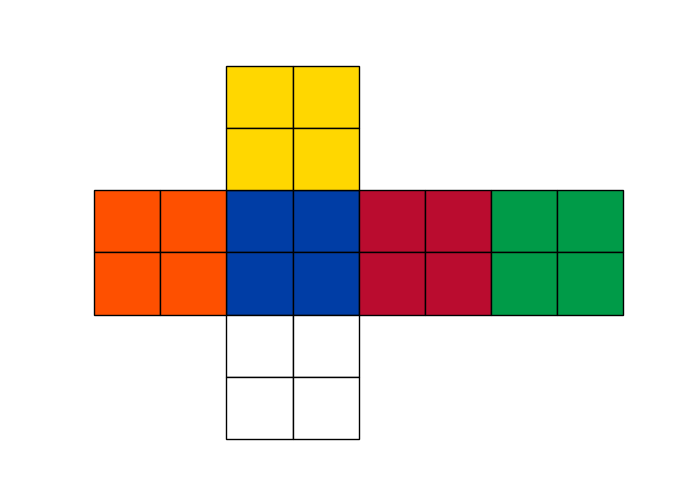

In [11]:
# Verify A*
assert path is not None

reconstruct = cube.clone()
for m in path:
    reconstruct = reconstruct.move(m)
plt.close("all")
print(astar_states)
reconstruct.render()

assert numpy.array_equal(reconstruct.state, cube.goal_state)

## Stats A*

In [12]:
# Run and test every case and heuristic for A*

# Check if the file exists
if os.path.exists("astar_data.pkl"):
    # Load the variables
    with open("astar_data.pkl", "rb") as f:
        ASTAR_TIMES, ASTAR_STATES, ASTAR_PATHS = pickle.load(f)
else:
    # Run and test every case and heuristic for A*
    ASTAR_TIMES, ASTAR_STATES, ASTAR_PATHS = test_algo(
        astar, ALL_CASES, [heuristic_1], True, {"heuristic": None}
    )

    # Save the variables
    with open("astar_data.pkl", "wb") as f:
        pickle.dump((ASTAR_TIMES, ASTAR_STATES, ASTAR_PATHS), f)

print(ASTAR_TIMES)
print(ASTAR_STATES)
print(ASTAR_PATHS)

[[0.04104757308959961, 0.3967728614807129, 7.410802602767944, 83.10122299194336]]
[[74, 1084, 17881, 213246]]
[[[<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>], [<Move.Rp: 3>, <Move.Up: 5>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>], [<Move.Rp: 3>, <Move.F: 1>, <Move.Rp: 3>, <Move.Rp: 3>, <Move.U: 2>, <Move.F: 1>, <Move.U: 2>, <Move.U: 2>, <Move.Fp: 4>], [<Move.R: 0>, <Move.Fp: 4>, <Move.R: 0>, <Move.Fp: 4>, <Move.Fp: 4>, <Move.Up: 5>, <Move.F: 1>, <Move.U: 2>, <Move.U: 2>, <Move.F: 1>, <Move.Up: 5>]]]


# BFS

BFS 

In [13]:
def construct_road_bfs(
    common_state: Cube,
    road_to_common_state: Dict[str, Tuple[Cube, Move]],
    road_to_end: Dict[str, Tuple[Cube, Move]],
) -> List:
    # Create the road from input to common state
    p1, m1 = road_to_common_state[common_state.hash()]
    road = []
    while m1:
        road.append(m1)
        p1, m1 = road_to_common_state[p1.hash()]
    road.reverse()

    # Create the road from common state to input
    p2, m2 = road_to_end[common_state.hash()]
    road_rev = []
    while m2:
        road_rev.append(m2.opposite())
        p2, m2 = road_to_end[p2.hash()]

    return road + road_rev


def bfs_bidirectional(cube: Cube) -> Tuple[List, int]:
    curr_cube: Cube
    curr_cube_reversed: Cube

    direction = 1
    cube = cube.clone()
    queue = [cube]
    discovered = {cube.hash(): (0, cube)}
    road = {cube.hash(): (None, None)}

    cube_reversed = cube.clone()
    aux = cube_reversed.state
    cube_reversed.state = cube_reversed.goal_state
    cube_reversed.goal_state = aux
    queue_reverse = [cube_reversed]

    discovered_reversed = {cube_reversed.hash(): (0, cube_reversed)}
    reversed_road = {cube_reversed.hash(): (None, None)}

    no_states = 0
    while queue and queue_reverse:
        if direction:
            curr_cube = queue.pop(0)
            no_states += 1

            _, common_cube = discovered_reversed.get(cube.hash(), (0, None))
            c, _ = discovered[curr_cube.hash()]

            if common_cube:
                return construct_road_bfs(common_cube, road, reversed_road), no_states

            for m in Move:
                tentative_cube = curr_cube.move(m)
                tentative_cube_hash = tentative_cube.hash()
                if discovered.get(tentative_cube_hash, None) is None:
                    queue.append(tentative_cube)
                    discovered[tentative_cube_hash] = (c + 1, tentative_cube)
                    road[tentative_cube_hash] = (curr_cube, m)
        else:
            curr_cube_reversed = queue_reverse.pop(0)
            no_states += 1

            _, common_cube = discovered.get(curr_cube_reversed.hash(), (False, None))
            c, _ = discovered_reversed[curr_cube_reversed.hash()]

            if common_cube:
                return construct_road_bfs(common_cube, road, reversed_road), no_states

            for m in Move:
                tentative_cube = curr_cube_reversed.move(m)
                tentative_cube.goal_state = curr_cube_reversed.goal_state
                tentative_cube_hash = tentative_cube.hash()
                if discovered_reversed.get(tentative_cube_hash, None) is None:
                    queue_reverse.append(tentative_cube)
                    discovered_reversed[tentative_cube_hash] = (c + 1, tentative_cube)
                    reversed_road[tentative_cube_hash] = (curr_cube_reversed, m)

        direction = direction ^ 1
    return [], no_states

## Test BFS

In [14]:
# Run BFS
cube = Cube(case1)
road, bfs_no_states = bfs_bidirectional(cube)

110


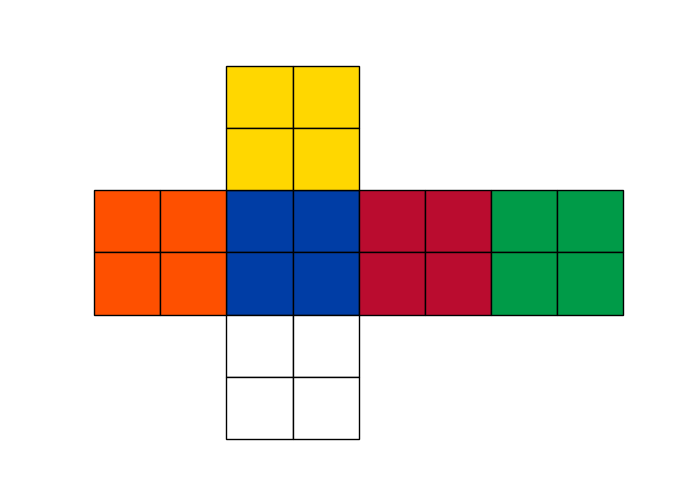

In [15]:
# Verify BFS

# Test road from input to end
reconstruct = cube.clone()
for m in road:
    reconstruct = reconstruct.move(m)
plt.close("all")
print(bfs_no_states)
reconstruct.render()

assert numpy.array_equal(reconstruct.state, cube.goal_state)

## Stats bfs

In [238]:
if os.path.exists("bfs_stats.pkl"):
    # Load the variables
    with open("bfs_stats.pkl", "rb") as f:
        BFS_TIMES, BFS_STATES, BFS_PATHS = pickle.load(f)
else:
    # Run and test every case for BFS
    BFS_TIMES, BFS_STATES, BFS_PATHS = test_algo(bfs_bidirectional, ALL_CASES, [None], True)
    with open("bfs_stats.pkl", "wb") as f:
        pickle.dump((BFS_TIMES, BFS_STATES, BFS_PATHS), f)

print(BFS_TIMES)
print(BFS_STATES)
print(BFS_PATHS)


[[0.04508662223815918, 0.07548761367797852, 0.28054070472717285, 1.113255500793457]]
[[110, 242, 1016, 3880]]
[[[<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>], [<Move.U: 2>, <Move.F: 1>, <Move.Up: 5>, <Move.Rp: 3>, <Move.Up: 5>, <Move.Rp: 3>, <Move.F: 1>], [<Move.Rp: 3>, <Move.F: 1>, <Move.R: 0>, <Move.Up: 5>, <Move.Fp: 4>, <Move.Fp: 4>, <Move.U: 2>, <Move.F: 1>, <Move.R: 0>], [<Move.R: 0>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.F: 1>, <Move.Up: 5>, <Move.F: 1>, <Move.Up: 5>, <Move.Up: 5>, <Move.F: 1>, <Move.Up: 5>]]]


# MCTS

## Heuristic 2

In [17]:
def big_faces_heuristic(cube: Cube) -> int:
    wrong_faces = sum(1 for x, goal in zip(cube.state, cube.goal_state) if x != goal)

    if wrong_faces == 0:
        return 0
    if wrong_faces == 8:
        return 1
    if wrong_faces == 15:
        return 3
    if wrong_faces < 8:
        return 2
    return wrong_faces / 2

## MCTS

In [18]:
from math import log, sqrt


class Node:
    def __init__(self, cube: Cube, parent=None, parent_action=None):
        self.cube = cube
        self.state = cube.state
        self.goal_state = cube.goal_state
        self.parent = parent
        self.parent_action = parent_action
        self.children = []
        self._number_of_visits = 0
        self._rewards = 0
        self._untried_actions = list(Move)
        self._tried_actions = []
        return

    def is_fully_expanded(self):
        # Check if all possible moves have been tried
        return len(self._untried_actions) == 0

    def is_final(self):
        return numpy.array_equal(self.state, self.goal_state)


def select_move(
    node: Node,
    c,
) -> Node:
    max = 0
    result = None
    child: Node
    for child in node.children:
        ucb = child._rewards / child._number_of_visits + c * sqrt(
            2 * log(node._number_of_visits) / child._number_of_visits
        )
        if ucb > max:
            max = ucb
            result = child

    return result


def construct_road_monte_carlo(node: Node) -> List:
    path = []
    while node.parent_action:
        path.append(node.parent_action)
        node = node.parent
    path.reverse()
    return path


def monte_carlo(cube: Cube, budget: int, C: float, heuristic) -> Cube:
    tree = Node(cube)
    no_states = 0
    while no_states < budget:
        # Start from root
        node = tree

        # SELECTION
        # Go down the tree until leaf or not fully expanded node
        while not node.is_final() and node.is_fully_expanded():
            node = select_move(node, C)

        # Return the first solution found
        if node.is_final():
            return construct_road_monte_carlo(node), no_states

        # EXPANSION
        # Create new node
        if not node.is_final():
            move = choice(node._untried_actions)

            # Skip useless states (R R', R R R etc)
            if move.opposite() == node.parent_action:
                node._untried_actions.remove(move)
                node._tried_actions.append(move)
                continue
            if move == node.parent_action == node.parent.parent_action:
                node._untried_actions.remove(move)
                node._tried_actions.append(move)
                continue

            node._untried_actions.remove(move)
            node._tried_actions.append(move)
            new_cube = node.cube.move(move)

            child = Node(new_cube, node, move)
            node.children.append(child)
            node = child

        # If the new node is a solution, return it
        if node.is_final():
            return construct_road_monte_carlo(node), no_states

        # ROLLOUT
        # Simulate game until timeout or solution
        timeout = 14
        curr_cube = node.cube.clone()
        best_found = heuristic(curr_cube)
        last_move = node.parent_action
        previous_move = node.parent.parent_action
        while (
            not numpy.array_equal(curr_cube.state, curr_cube.goal_state) and timeout > 0
        ):
            moves = list(Move)

            # Skip useless states (R R', R R R etc)
            moves.remove(last_move.opposite())
            if last_move == previous_move:
                moves.remove(last_move)

            previous_move = last_move
            last_move = choice(moves)
            curr_cube = curr_cube.move(last_move)
            tentative = heuristic(curr_cube)
            # Select best
            if tentative < best_found:
                best_found = tentative
            timeout -= 1

        if best_found == 0:
            reward = 1000000
        else:
            reward = 14 - best_found

        # Back propagation
        while node is not None:
            node._number_of_visits += 1
            node._rewards += reward
            node = node.parent
        no_states += 1
    return [], no_states

## Test MCTS

In [19]:
# Run Monte Carlo
cube = Cube(case1)
monte_carlo_path, monte_no_states = monte_carlo(cube, 20000, 0.1, heuristic_1)

In [20]:
monte_carlo_path

[<Move.F: 1>,
 <Move.Up: 5>,
 <Move.Up: 5>,
 <Move.Fp: 4>,
 <Move.Up: 5>,
 <Move.F: 1>,
 <Move.R: 0>,
 <Move.Up: 5>,
 <Move.Rp: 3>,
 <Move.Fp: 4>,
 <Move.Up: 5>,
 <Move.F: 1>,
 <Move.U: 2>]

12645


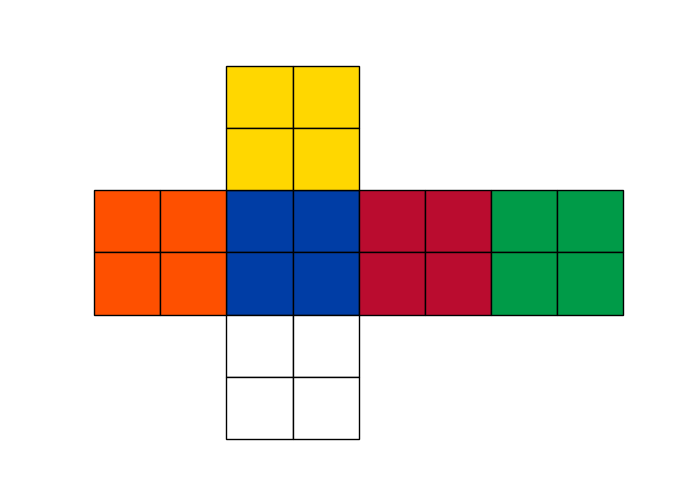

In [21]:
plt.close("all")
reconstruct = cube.clone()
for move in monte_carlo_path:
    reconstruct = reconstruct.move(move)
print(monte_no_states)
reconstruct.render()

assert numpy.array_equal(reconstruct.state, cube.goal_state)

## Stats MCTS

In [22]:
def test_monte_carlo(filename, heuristics):
    if os.path.exists(filename):
        # Load the variables
        with open(filename, "rb") as f:
            (
                MCTS_TIMES_ALL_BUDGETS,
                MCTS_STATES_ALL_BUDGETS,
                MCTS_PATHS_ALL_BUDGETS,
            ) = pickle.load(f)
    else:
        MCTS_TIMES_ALL_BUDGETS = {}
        MCTS_STATES_ALL_BUDGETS = {}
        MCTS_PATHS_ALL_BUDGETS = {}

        for budget in [1000, 5000, 10000, 20000]:
            for c in [0.5, 0.1]:
                for _ in range(20):
                    MCTS_TIMES, MCTS_STATES, MCTS_PATHS = test_algo(
                        monte_carlo,
                        ALL_CASES,
                        heuristics,
                        False,
                        {
                            "budget": budget,
                            "C": c,
                            "heuristic": None,
                        },
                    )

                    # Add MCTS_TIMES to previous value from dict
                    if (budget, c) in MCTS_TIMES_ALL_BUDGETS:
                        MCTS_TIMES_ALL_BUDGETS[(budget, c)] = [
                            [a + b for a, b in zip(x, y)]
                            for x, y in zip(
                                MCTS_TIMES_ALL_BUDGETS[(budget, c)], MCTS_TIMES
                            )
                        ]
                    else:
                        MCTS_TIMES_ALL_BUDGETS[(budget, c)] = MCTS_TIMES

                    # Add MCTS_STATES to previous value from dict
                    if (budget, c) in MCTS_STATES_ALL_BUDGETS:
                        MCTS_STATES_ALL_BUDGETS[(budget, c)] = [
                            [a + b for a, b in zip(x, data)]
                            for x, data in zip(
                                MCTS_STATES_ALL_BUDGETS[(budget, c)], MCTS_STATES
                            )
                        ]
                    else:
                        MCTS_STATES_ALL_BUDGETS[(budget, c)] = MCTS_STATES

                    # Add MCTS_PATHS to previous value from dict
                    if (budget, c) in MCTS_PATHS_ALL_BUDGETS:
                        MCTS_PATHS_ALL_BUDGETS[(budget, c)] = [
                            [a + len(path) for a, path in zip(x, data)]
                            for x, data in zip(
                                MCTS_PATHS_ALL_BUDGETS[(budget, c)], MCTS_PATHS
                            )
                        ]
                    else:
                        MCTS_PATHS_ALL_BUDGETS[(budget, c)] = [
                            [len(path) for path in data] for data in MCTS_PATHS
                        ]

        # # Divide all values in MCTS_TIMES_ALL_BUDGETS by 20
        for key in MCTS_TIMES_ALL_BUDGETS:
            MCTS_TIMES_ALL_BUDGETS[key] = [
                [value / 20 for value in sublist]
                for sublist in MCTS_TIMES_ALL_BUDGETS[key]
            ]

        # # Divide all values in MCTS_STATES_ALL_BUDGETS by 20
        for key in MCTS_STATES_ALL_BUDGETS:
            MCTS_STATES_ALL_BUDGETS[key] = [
                [value / 20 for value in sublist]
                for sublist in MCTS_STATES_ALL_BUDGETS[key]
            ]

        # # Divide all values in MCTS_PATHS_ALL_BUDGETS by 20
        for key in MCTS_PATHS_ALL_BUDGETS:
            MCTS_PATHS_ALL_BUDGETS[key] = [
                [value / 20 for value in sublist]
                for sublist in MCTS_PATHS_ALL_BUDGETS[key]
            ]

        # Save the variables
        with open(filename, "wb") as f:
            pickle.dump(
                (
                    MCTS_TIMES_ALL_BUDGETS,
                    MCTS_STATES_ALL_BUDGETS,
                    MCTS_PATHS_ALL_BUDGETS,
                ),
                f,
            )
    return MCTS_TIMES_ALL_BUDGETS, MCTS_STATES_ALL_BUDGETS, MCTS_PATHS_ALL_BUDGETS

In [23]:
(
    MCTS_TIMES_ALL_BUDGETS,
    MCTS_STATES_ALL_BUDGETS,
    MCTS_PATHS_ALL_BUDGETS,
) = test_monte_carlo("mcts_data.pkl", [heuristic_1, big_faces_heuristic])
print(MCTS_TIMES_ALL_BUDGETS)
print(MCTS_STATES_ALL_BUDGETS)
print(MCTS_PATHS_ALL_BUDGETS)

{(1000, 0.5): [[0.7005413413047791, 0.9599120378494262, 1.0119553208351135, 1.0017042636871338], [0.7814407706260681, 0.9024939894676208, 1.0487408280372619, 1.0348185300827026]], (1000, 0.1): [[0.7927983164787292, 0.991893982887268, 0.9945929169654846, 1.0718065977096558], [0.9643370747566223, 1.012404990196228, 1.0895219564437866, 1.0741155385971068]], (5000, 0.5): [[0.5882188439369201, 4.316745257377624, 5.386357820034027, 5.513725674152374], [3.615264058113098, 4.197175514698029, 5.131323301792145, 5.457218861579895]], (5000, 0.1): [[2.0426272988319396, 2.618926525115967, 4.241284573078156, 5.729184710979462], [4.154909300804138, 5.21370849609375, 5.463805484771728, 6.5480090260505674]], (10000, 0.5): [[0.756748616695404, 3.6273043513298036, 9.40529923439026, 10.44956033229828], [4.176067221164703, 8.677146291732788, 8.573231494426727, 10.151687836647033]], (10000, 0.1): [[3.39764164686203, 7.151474750041961, 7.405479454994202, 10.504720675945283], [7.668773794174195, 9.38442578315

In [66]:
def test_mcts_stats(case, budget, C, heuristic, runs=20):
    wins = 0
    average_states = 0
    average_states_when_solution = 0
    average_path_len = 0
    average_run_time = 0
    average_run_time_when_solution = 0
    for _ in range(runs):
        cube = Cube(case)
        start = time.time()
        path, states = monte_carlo(cube, budget, C, heuristic)
        finish = time.time()
        average_run_time += finish - start
        average_states += states
        if path:
            wins += 1
            average_path_len += len(path)
            average_run_time_when_solution += finish - start
            average_states_when_solution += states
    return (
        wins / runs,
        average_states / runs,
        (average_states_when_solution / wins) if wins else 0,
        (average_path_len / wins) if wins else 0,
        average_run_time / runs,
        (average_run_time_when_solution / wins) if wins else 0,
    )

# Pattern Database

In [25]:
def create_pattern_database():
    PATTERN_DATABASE = {}
    cube = Cube(scrambled=False)
    PATTERN_DATABASE[cube.hash()] = 0

    queue = [cube]
    for distance in range(1, 8):
        for _ in range(6 ** (distance - 1)):
            init = queue.pop(0)
            for m in Move:
                new_cube = init.move(m)
                queue.append(new_cube)
                if new_cube.hash() not in PATTERN_DATABASE:
                    PATTERN_DATABASE[new_cube.hash()] = distance
    return PATTERN_DATABASE

In [26]:
PATTERN_DATABASE = create_pattern_database()

In [27]:
def new_heuristic(cube: Cube):
    return PATTERN_DATABASE.get(cube.hash(), heuristic_1(cube))


def new_heuristic_alone(cube: Cube):
    return PATTERN_DATABASE.get(cube.hash(), 14)

In [28]:
# Test pattern database

ALL_MOVES = list(Move)


def test_new_heuristic(moves):
    # Since we are using random moves, we might end up with a sequence
    # That could be solved in less moves
    assert new_heuristic(Cube(moves)) <= len(moves)


for _ in range(1000):
    for distance in range(1, 8):
        moves = [choice(ALL_MOVES) for _ in range(distance)]
        test_new_heuristic(moves)

# Some static test cases
assert new_heuristic(Cube("R U")) == 2
assert new_heuristic(Cube("R U R")) == 3
assert new_heuristic(Cube("R U F R U")) == 5

In [29]:
# Run A* with PATTERN heuristic
cube = Cube(case1)
path, states = astar(cube, new_heuristic_alone)

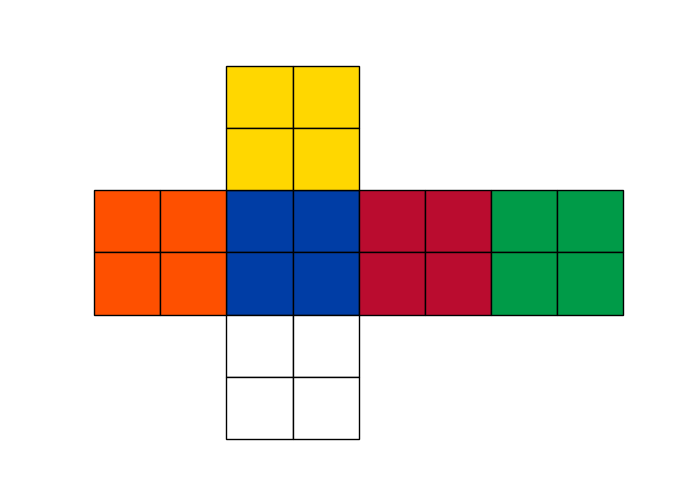

In [30]:
reconstruct = cube.clone()
for m in path:
    reconstruct = reconstruct.move(m)

plt.close("all")
reconstruct.render()
assert numpy.array_equal(reconstruct.state, cube.goal_state)

# A* Pattern Database

In [92]:
# Run and test every case and PATTER_DB heuristic for A*

# Check if the file exists
if os.path.exists("astar_data_pdb.pkl"):
    # Load the variables
    with open("astar_data_pdb.pkl", "rb") as f:
        ASTAR_TIMES_PDB, ASTAR_STATES_PDB, ASTAR_PATHS_PDB = pickle.load(f)
else:
    # Run and test every case and heuristic for A*
    ASTAR_TIMES_PDB, ASTAR_STATES_PDB, ASTAR_PATHS_PDB = test_algo(
        astar,
        ALL_CASES,
        [new_heuristic, new_heuristic_alone],
        True,
        {"heuristic": None},
    )

    # Save the variables
    with open("astar_data_pdb.pkl", "wb") as f:
        pickle.dump((ASTAR_TIMES_PDB, ASTAR_STATES_PDB, ASTAR_PATHS_PDB), f)

print(ASTAR_TIMES_PDB)
print(ASTAR_STATES_PDB)
print(ASTAR_PATHS_PDB)

[[0.006394624710083008, 0.18954896926879883, 6.9454874992370605, 83.24540877342224], [0.002516031265258789, 0.0023932456970214844, 0.003002166748046875, 0.022457122802734375]]
[[6, 523, 18241, 226180], [6, 8, 10, 70]]
[[[<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>], [<Move.Rp: 3>, <Move.Up: 5>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>], [<Move.Rp: 3>, <Move.F: 1>, <Move.Rp: 3>, <Move.Rp: 3>, <Move.U: 2>, <Move.F: 1>, <Move.U: 2>, <Move.U: 2>, <Move.Fp: 4>], [<Move.U: 2>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>, <Move.Rp: 3>, <Move.Fp: 4>, <Move.R: 0>, <Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.F: 1>]], [[<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>], [<Move.Rp: 3>, <Move.Up: 5>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>], [<Move.U: 2>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>, <Move.Up: 5>, <Move.R: 0>, <Move.F: 1>, <Move.Up: 5>, <Move.Fp: 4>], [<Move.U: 2>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1

# MCTS Pattern Database

In [32]:
plt.close("all")

# Run Monte Carlo
cube = Cube(case1)
monte_carlo_path, monte_no_states = monte_carlo(cube, 20000, 0.5, new_heuristic_alone)

No such comm: f46c84b404ee44cfa25da15b4e0b0a2e


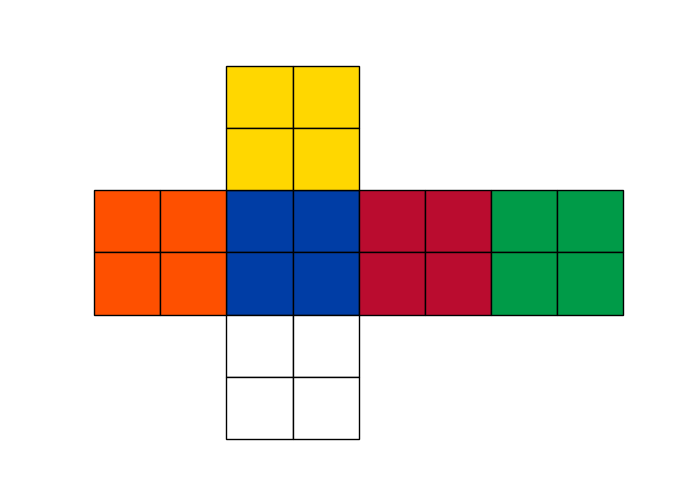

In [33]:
reconstruct = cube.clone()
for m in monte_carlo_path:
    reconstruct = reconstruct.move(m)

plt.close("all")
reconstruct.render()
assert numpy.array_equal(reconstruct.state, cube.goal_state)

In [34]:
# Run all tests for Monte Carlo
(
    MCTS_TIMES_ALL_BUDGETS_PDB,
    MCTS_STATES_ALL_BUDGETS_PDB,
    MCTS_PATHS_ALL_BUDGETS_PDB,
) = test_monte_carlo("mcts_data_pdb.pkl", [new_heuristic, new_heuristic_alone])

In [35]:
print(MCTS_TIMES_ALL_BUDGETS_PDB)
print(MCTS_STATES_ALL_BUDGETS_PDB)
print(MCTS_PATHS_ALL_BUDGETS_PDB)

{(1000, 0.5): [[1.0515746474266052, 1.0800398945808412, 1.0684046149253845, 1.071292269229889], [0.02386282682418823, 0.04009734392166138, 0.06083831787109375, 0.16417989730834961]], (1000, 0.1): [[1.1127421140670777, 1.131382668018341, 1.121044933795929, 1.129552435874939], [0.022315919399261475, 0.03645901679992676, 0.05559364557266235, 0.129047691822052]], (5000, 0.5): [[2.410819435119629, 4.8548007845878605, 5.419167864322662, 5.4780322194099424], [0.024282753467559814, 0.04172955751419068, 0.05661242008209229, 0.16106635332107544]], (5000, 0.1): [[5.577533602714539, 5.65093983411789, 5.613141059875488, 5.6479573249816895], [0.022321140766143797, 0.03555670976638794, 0.06850872039794922, 0.11740008592605591]], (10000, 0.5): [[3.5220232009887695, 7.972315347194671, 10.771556389331817, 10.88283005952835], [0.023208725452423095, 0.04160583019256592, 0.06175029277801514, 0.14641284942626953]], (10000, 0.1): [[10.100920331478118, 11.37171767950058, 11.369035255908965, 11.333051931858062

# Plot and statistics section

## A* vs BFS

In [148]:
print(ASTAR_PATHS)
ASTAR_PATHS_PATHS_LENS = [[len(path) for path in data] for data in ASTAR_PATHS]
print(ASTAR_PATHS_PATHS_LENS)

print(BFS_PATHS)
BFS_PATHS_LEN = [[len(path) for path in data] for data in BFS_PATHS]
print(BFS_PATHS_LEN)

[[[<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>], [<Move.Rp: 3>, <Move.Up: 5>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.Rp: 3>, <Move.F: 1>], [<Move.Rp: 3>, <Move.F: 1>, <Move.Rp: 3>, <Move.Rp: 3>, <Move.U: 2>, <Move.F: 1>, <Move.U: 2>, <Move.U: 2>, <Move.Fp: 4>], [<Move.R: 0>, <Move.Fp: 4>, <Move.R: 0>, <Move.Fp: 4>, <Move.Fp: 4>, <Move.Up: 5>, <Move.F: 1>, <Move.U: 2>, <Move.U: 2>, <Move.F: 1>, <Move.Up: 5>]]]
[[5, 7, 9, 11]]
[[[<Move.Up: 5>, <Move.F: 1>, <Move.R: 0>, <Move.U: 2>, <Move.Rp: 3>], [<Move.U: 2>, <Move.F: 1>, <Move.Up: 5>, <Move.Rp: 3>, <Move.Up: 5>, <Move.Rp: 3>, <Move.F: 1>], [<Move.Rp: 3>, <Move.F: 1>, <Move.R: 0>, <Move.Up: 5>, <Move.Fp: 4>, <Move.Fp: 4>, <Move.U: 2>, <Move.F: 1>, <Move.R: 0>], [<Move.R: 0>, <Move.Fp: 4>, <Move.R: 0>, <Move.F: 1>, <Move.F: 1>, <Move.Up: 5>, <Move.F: 1>, <Move.Up: 5>, <Move.Up: 5>, <Move.F: 1>, <Move.Up: 5>]]]
[[5, 7, 9, 11]]


### PATH LENGTH

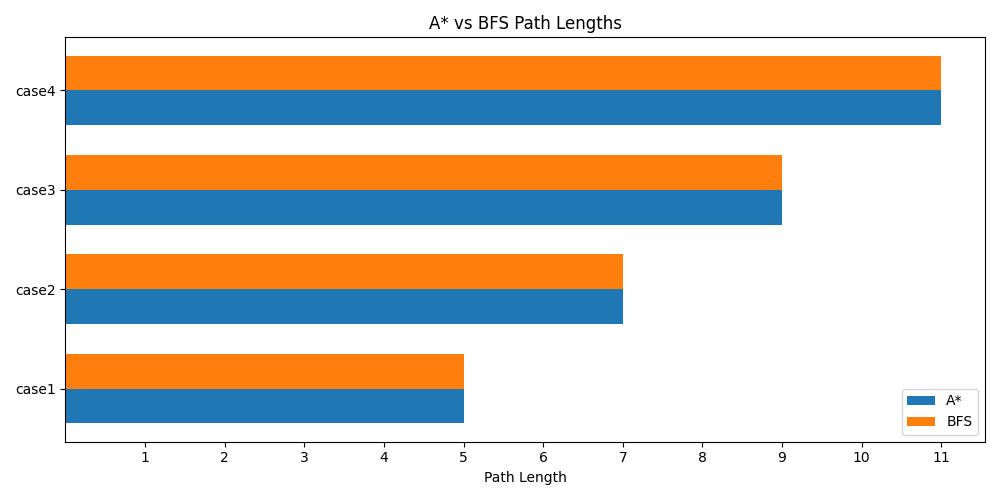

In [149]:
plt.close("all")

# Data for A* and BFS paths lengths
astar_paths_lens = ASTAR_PATHS_PATHS_LENS[0]
bfs_paths_lens = BFS_PATHS_LEN[0]

# X-axis labels
cases = ["case1", "case2", "case3", "case4"]

# Create a figure and a grid of subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5))

# Create horizontal bar chart for A* and BFS on the subplot
height = 0.35  # height of the bars
y = range(len(cases))

# Plot A* path lengths
ax.barh(y, astar_paths_lens, height, label="A*")
# Plot BFS path lengths
ax.barh([i + height for i in y], bfs_paths_lens, height, label="BFS")

# Set y-axis labels and ticks
ax.set_yticks([i + height / 2 for i in y])
ax.set_yticklabels(cases)

# Set x-axis label and ticks
ax.set_xlabel("Path Length")
ax.set_xticks(range(1, max(max(astar_paths_lens), max(bfs_paths_lens)) + 1))

# Set title and legend
ax.set_title("A* vs BFS Path Lengths")
ax.legend()

# Display the figure
plt.tight_layout()
plt.show()
plt.savefig("plots/ASTAR_BFS_PATHS.png", dpi=300)

In [38]:
print(ASTAR_TIMES)
print(BFS_TIMES)

[[0.04104757308959961, 0.3967728614807129, 7.410802602767944, 83.10122299194336]]
[[0.04508662223815918, 0.07548761367797852, 0.28054070472717285, 1.113255500793457]]


### TIME

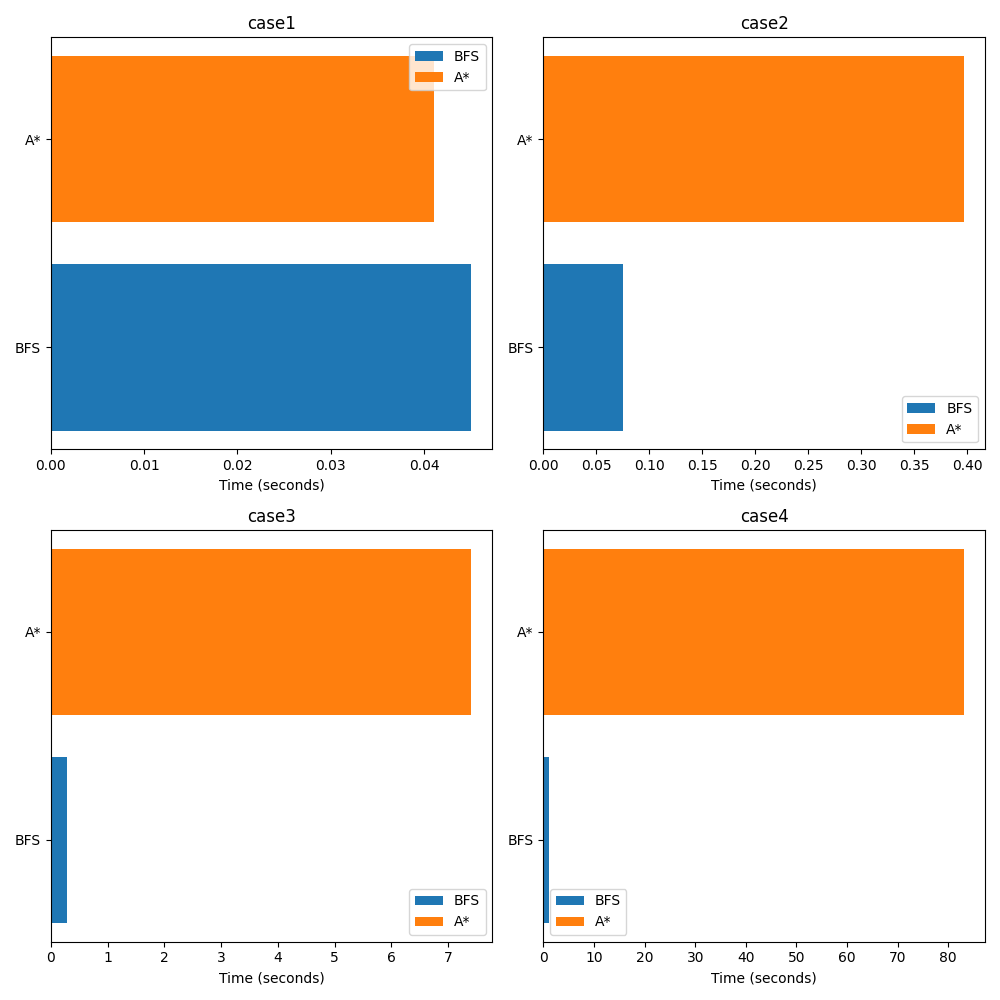

In [150]:
# Data for A* and BFS times
astar_times = ASTAR_TIMES[0]
bfs_times = BFS_TIMES[0]

# X-axis labels
cases = ["case1", "case2", "case3", "case4"]

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Iterate over each case and create a subplot for it
for i, case in enumerate(cases):
    # Get the corresponding subplot
    ax = axs[i // 2, i % 2]

    # Plot BFS times
    ax.barh(0, bfs_times[i], label="BFS")
    # Plot A* times
    ax.barh(1, astar_times[i], label="A*")

    # Set y-axis labels and ticks
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["BFS", "A*"])

    # Set x-axis label and ticks
    ax.set_xlabel("Time (seconds)")

    # Set title and legend
    ax.set_title(case)
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
plt.savefig("plots/ASTAR_BFS_TIMES.png", dpi=300)

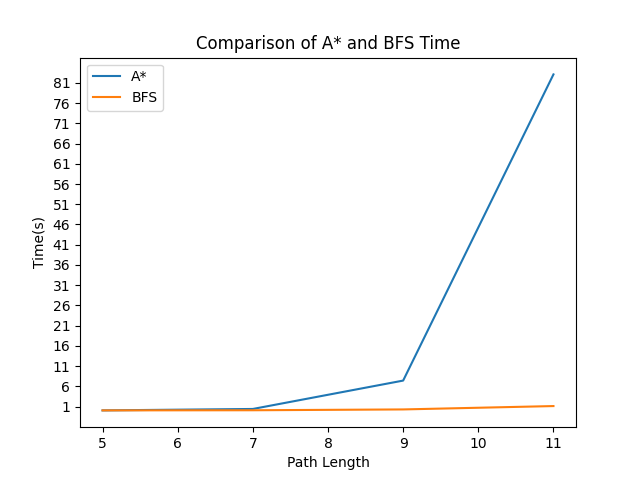

In [158]:

plt.close("all")

# Data for A* and BFS times
astar_times = ASTAR_TIMES[0]
bfs_times = BFS_TIMES[0]

# Plotting the times
plt.plot(astar_paths_lens, astar_times, label="A*")
plt.plot(bfs_paths_lens, bfs_times, label="BFS")

# Adding labels and title
plt.xlabel("Path Length")
plt.ylabel("Time(s)")
plt.title("Comparison of A* and BFS Time")
plt.yticks(range(1, int(max(astar_times)) + 1, 5))  # Set y-axis grid
# Adding legend
plt.legend()

# Display the plot
plt.show()
plt.savefig("plots/ASTAR_BFS_TIMES_LINES_4.png", dpi=300)

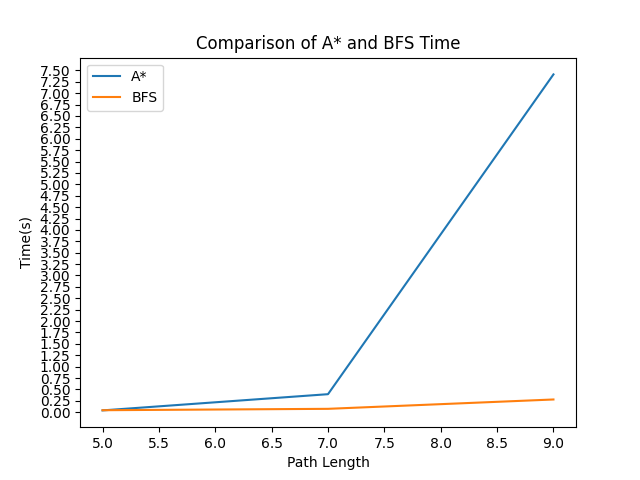

In [159]:

plt.close("all")

# Data for A* and BFS times
astar_times = ASTAR_TIMES[0]
bfs_times = BFS_TIMES[0]

# Plotting the times
plt.plot(astar_paths_lens[:-1], astar_times[:-1], label="A*")
plt.plot(bfs_paths_lens[:-1], bfs_times[:-1], label="BFS")

# Adding labels and title
plt.xlabel("Path Length")
plt.ylabel("Time(s)")
plt.title("Comparison of A* and BFS Time")

# Set yticks for every quarter of a second
yticks = np.arange(0, max(max(astar_times[:-1]), max(bfs_times[:-1])) + 0.25, 0.25)
plt.yticks(yticks)

# Adding legend
plt.legend()

# Display the plot
plt.show()
plt.savefig("plots/ASTAR_BFS_TIMES_LINES.png", dpi=300)

### STATES

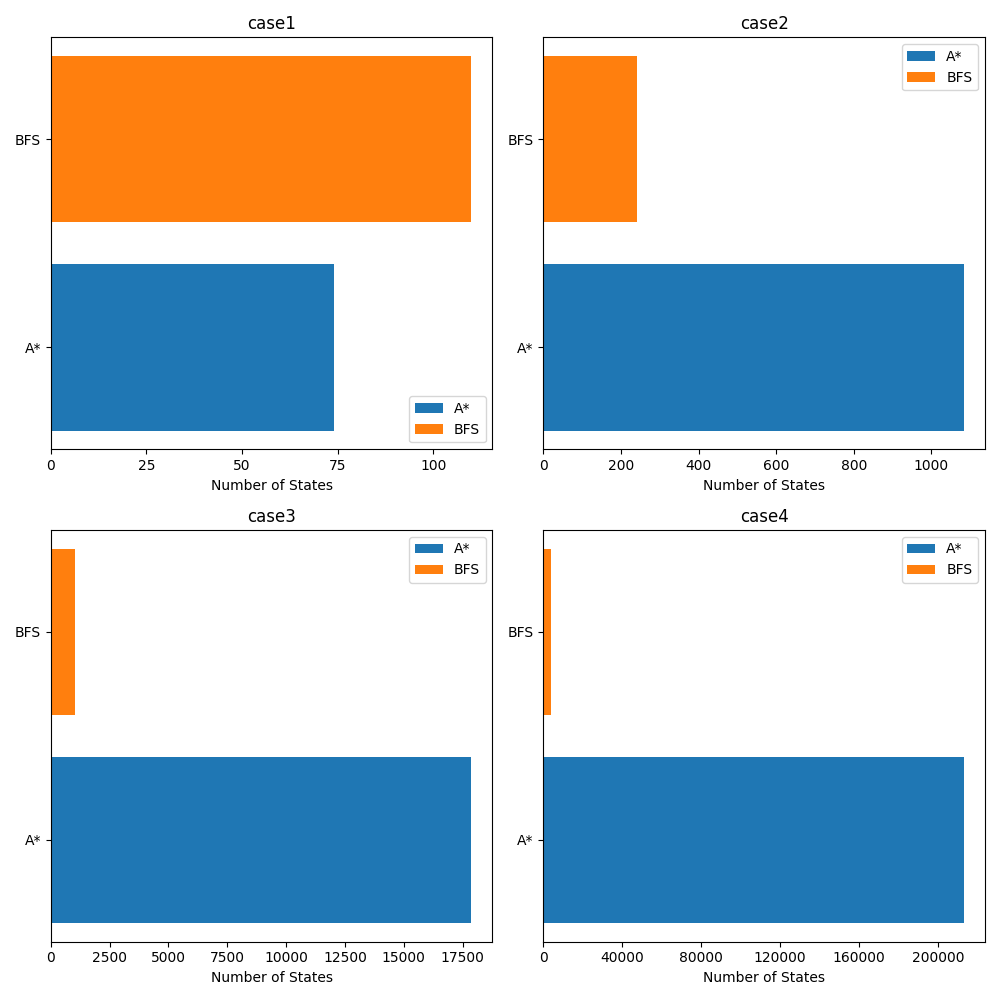

In [180]:
plt.close("all")

# Data for ASTAR and BFS states
astar_states = ASTAR_STATES[0]
bfs_states = BFS_STATES[0]

# X-axis labels
cases = ["case1", "case2", "case3", "case4"]

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

# Iterate over each case and create a subplot for it
for i, case in enumerate(cases):
    # Get the corresponding subplot
    ax = axs[i // 2, i % 2]

    # Plot ASTAR states
    ax.barh(0, astar_states[i], label="A*")
    # Plot BFS states
    ax.barh(1, bfs_states[i], label="BFS")

    # Set y-axis labels and ticks
    ax.set_yticks([0, 1])
    ax.set_yticklabels(["A*", "BFS"])

    # Set x-axis label and ticks
    ax.set_xlabel("Number of States")
    ax.set_xticks(
        range(
            0,
            int(max(astar_states[i], bfs_states[i])) + 1,
            25
            if case == "case1"
            else 200
            if case == "case2"
            else 2500
            if case == "case3"
            else 40000,
        )
    )

    # Set title and legend
    ax.set_title(case)
    ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
plt.savefig("plots/ASTAR_BFS_STATES.png", dpi=300)

In [161]:
average_time_per_state_astar = 0
for duration, states in zip(ASTAR_TIMES[0], ASTAR_STATES[0]):
    average_time_per_state_astar += duration * 100 / states
average_time_per_state_astar /= len(ASTAR_TIMES[0])

average_time_per_state_bfs = 0
for duration, states in zip(BFS_TIMES[0], BFS_STATES[0]):
    average_time_per_state_bfs += duration * 100 / states
average_time_per_state_bfs /= len(BFS_TIMES[0])

print(average_time_per_state_astar)
print(average_time_per_state_bfs)

0.04312178280776887
0.03212137334012635


In [181]:
path_score_h1 = 0
path_score_h2 = 0

time_score_h1 = 0
time_score_h2 = 0

state_score_h1 = 0
state_score_h2 = 0


for budget in [1000, 5000, 10000, 20000]:
    for c in [0.5, 0.1]:
        values_h1 = MCTS_PATHS_ALL_BUDGETS[(budget, c)][0]
        values_h2 = MCTS_PATHS_ALL_BUDGETS[(budget, c)][1]
        for v1, v2 in zip(values_h1, values_h2):
            if v1 < v2:
                path_score_h1 += 1
            elif v1 > v2:
                path_score_h2 += 1

        values_h1 = MCTS_TIMES_ALL_BUDGETS[(budget, c)][0]
        values_h2 = MCTS_TIMES_ALL_BUDGETS[(budget, c)][1]
        for v1, v2 in zip(values_h1, values_h2):
            if v1 < v2:
                time_score_h1 += 1
            elif v1 > v2:
                time_score_h2 += 1

        values_h1 = MCTS_STATES_ALL_BUDGETS[(budget, c)][0]
        values_h2 = MCTS_STATES_ALL_BUDGETS[(budget, c)][1]
        for v1, v2 in zip(values_h1, values_h2):
            if v1 < v2:
                state_score_h1 += 1
            elif v1 > v2:
                state_score_h2 += 1

if path_score_h1 < path_score_h2:
    print("Path score: Heuristic 2 wins")
elif path_score_h1 > path_score_h2:
    print("Path score: Heuristic 1 wins")
else:
    print("Path score: Draw")

if time_score_h1 < time_score_h2:
    print("Time score: Heuristic 2 wins")
elif time_score_h1 > time_score_h2:
    print("Time score: Heuristic 1 wins")
else:
    print("Time score: Draw")

if state_score_h1 < state_score_h2:
    print("State score: Heuristic 2 wins")
elif state_score_h1 > state_score_h2:
    print("State score: Heuristic 1 wins")
else:
    print("State score: Draw")

Path score: Heuristic 1 wins
Time score: Heuristic 1 wins
State score: Heuristic 1 wins


## MCTS

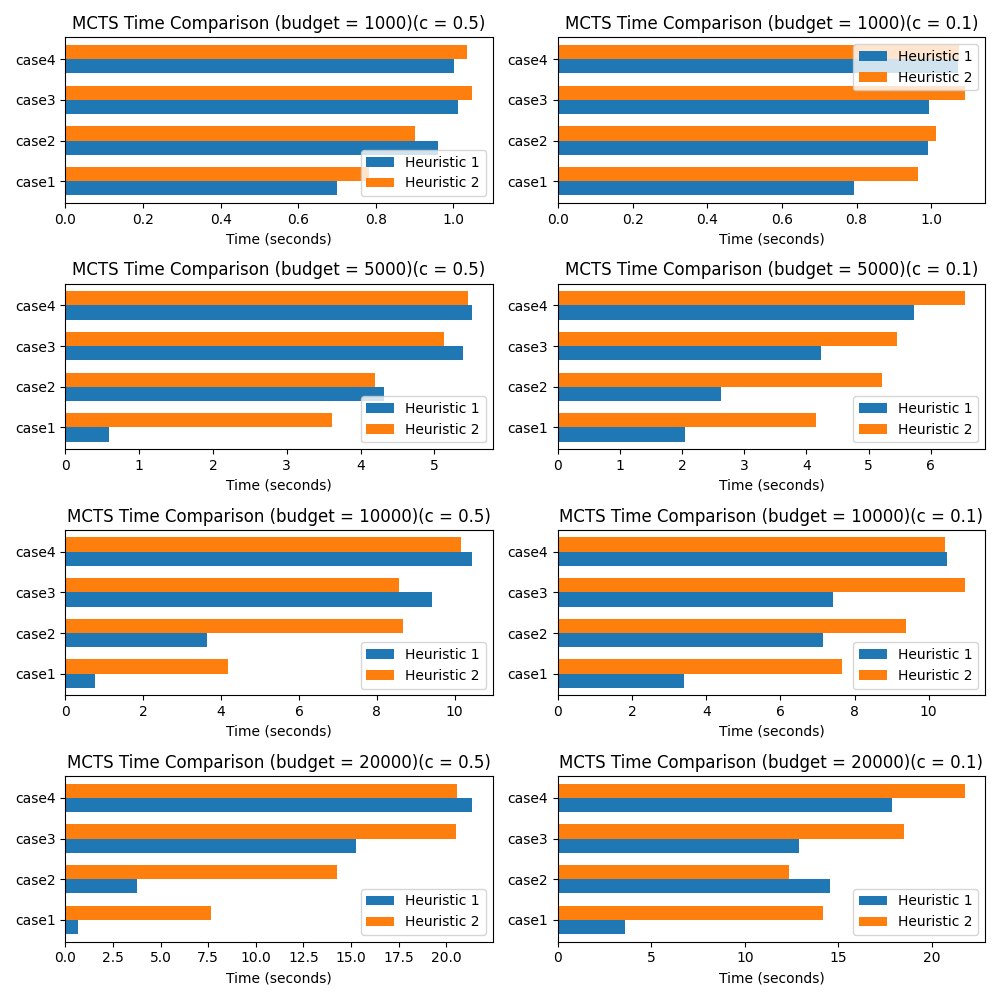

In [182]:
# Data for MCTS times
budgets = [1000, 5000, 10000, 20000]
cs = [0.5, 0.1]
cases = ["case1", "case2", "case3", "case4"]
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=len(budgets), ncols=len(cs), figsize=(10, 10))

# Iterate over each budget and c value and create a subplot for it
for i, budget in enumerate(budgets):
    for j, c in enumerate(cs):
        # Get the corresponding subplot
        ax = axs[i, j]

        # Get the MCTS times for the current budget and c value
        heuristic_1_times = MCTS_TIMES_ALL_BUDGETS[(budget, c)][0]
        heuristic_2_times = MCTS_TIMES_ALL_BUDGETS[(budget, c)][1]

        # Create horizontal bar chart for MCTS times on the subplot
        height = 0.35  # height of the bars
        y = range(len(heuristic_1_times))

        # Plot heuristic 1 times
        ax.barh(y, heuristic_1_times, height, label="Heuristic 1")
        # Plot heuristic 2 times
        ax.barh([k + height for k in y], heuristic_2_times, height, label="Heuristic 2")

        # Set y-axis labels and ticks
        ax.set_yticks([k + height / 2 for k in y])
        ax.set_yticklabels(cases)

        # Set x-axis label and ticks
        ax.set_xlabel("Time (seconds)")

        # Set title and legend
        ax.set_title(f"MCTS Time Comparison (budget = {budget})(c = {c})")
        ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
plt.savefig("plots/MCTS_HEURISTICS.png", dpi=300)

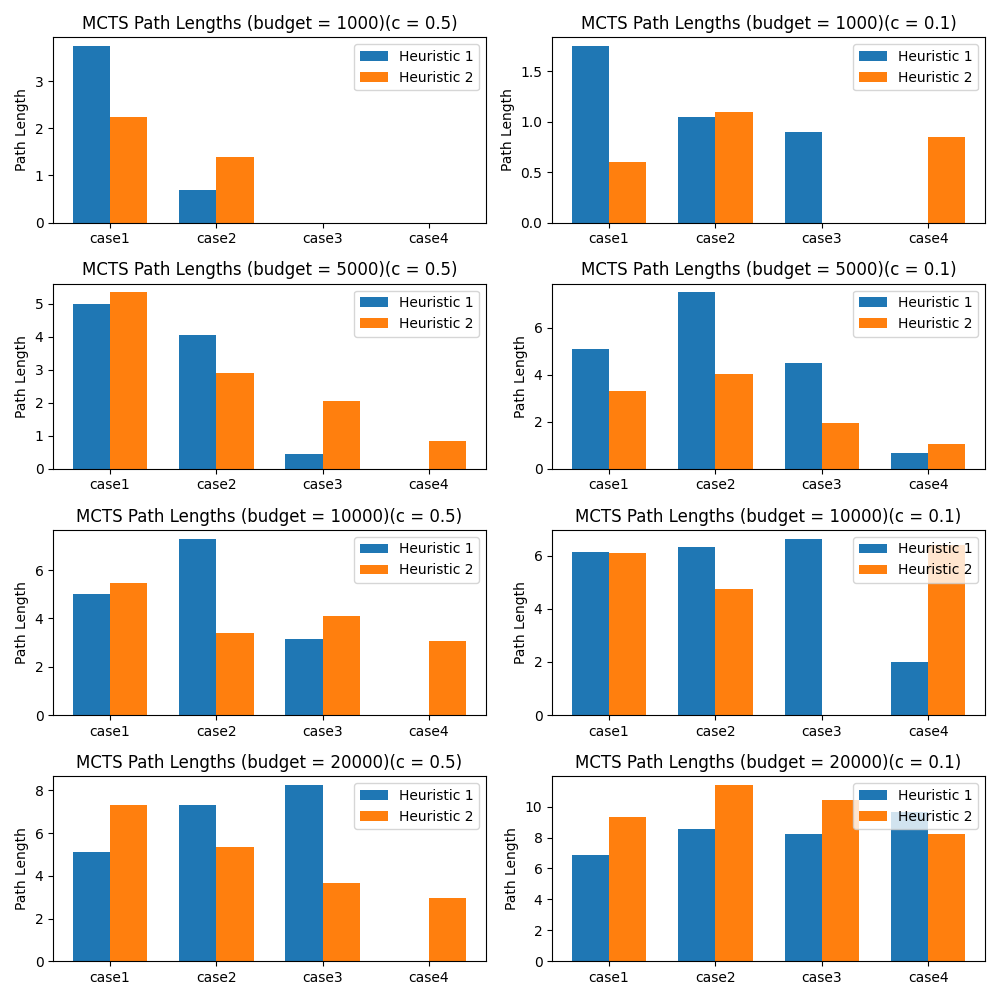

In [183]:
plt.close("all")
# Data for MCTS path lengths
budgets = [1000, 5000, 10000, 20000]
cs = [0.5, 0.1]
cases = ["case1", "case2", "case3", "case4"]
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=len(budgets), ncols=len(cs), figsize=(10, 10))

# Iterate over each budget and c value and create a subplot for it
for i, budget in enumerate(budgets):
    for j, c in enumerate(cs):
        # Get the corresponding subplot
        ax = axs[i, j]

        # Get the MCTS path lengths for the current budget and c value
        heuristic_1_paths = MCTS_PATHS_ALL_BUDGETS[(budget, c)][0]
        heuristic_2_paths = MCTS_PATHS_ALL_BUDGETS[(budget, c)][1]

        # Create bar chart for MCTS path lengths on the subplot
        width = 0.35  # width of the bars
        x = range(len(heuristic_1_paths))

        # Plot heuristic 1 path lengths
        ax.bar(x, heuristic_1_paths, width, label="Heuristic 1")
        # Plot heuristic 2 path lengths
        ax.bar([k + width for k in x], heuristic_2_paths, width, label="Heuristic 2")

        # Set x-axis labels and ticks
        ax.set_xticks([k + width / 2 for k in x])
        ax.set_xticklabels(cases)

        # Set y-axis label and ticks
        ax.set_ylabel("Path Length")

        # Set title and legend
        ax.set_title(f"MCTS Path Lengths (budget = {budget})(c = {c})")
        ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
plt.savefig("plots/MCTS_HEURISTICS_PATHS.png", dpi=300)

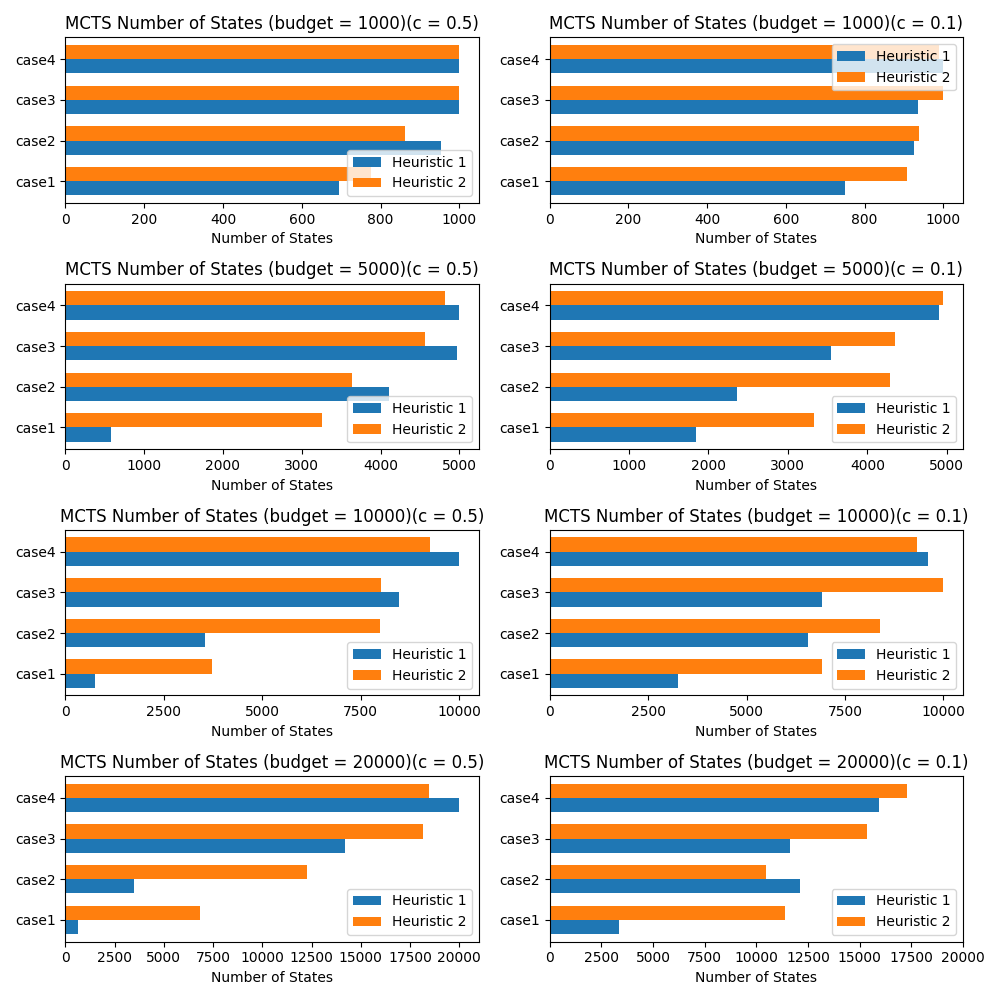

In [184]:
plt.close("all")
# Data for MCTS number of states
budgets = [1000, 5000, 10000, 20000]
cs = [0.5, 0.1]
cases = ["case1", "case2", "case3", "case4"]
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=len(budgets), ncols=len(cs), figsize=(10, 10))

# Iterate over each budget and c value and create a subplot for it
for i, budget in enumerate(budgets):
    for j, c in enumerate(cs):
        # Get the corresponding subplot
        ax = axs[i, j]

        # Get the MCTS number of states for the current budget and c value
        heuristic_1_states = MCTS_STATES_ALL_BUDGETS[(budget, c)][0]
        heuristic_2_states = MCTS_STATES_ALL_BUDGETS[(budget, c)][1]

        # Create horizontal bar chart for MCTS number of states on the subplot
        height = 0.35  # height of the bars
        y = range(len(heuristic_1_states))

        # Plot heuristic 1 number of states
        ax.barh(y, heuristic_1_states, height, label="Heuristic 1")
        # Plot heuristic 2 number of states
        ax.barh(
            [k + height for k in y], heuristic_2_states, height, label="Heuristic 2"
        )

        # Set y-axis labels and ticks
        ax.set_yticks([k + height / 2 for k in y])
        ax.set_yticklabels(cases)

        # Set x-axis label and ticks
        ax.set_xlabel("Number of States")
        xtick = range(
            0, budget + 1, 200 if budget == 1000 else 1000 if budget < 10000 else 2500
        )
        ax.set_xticks(xtick)

        # Set title and legend
        ax.set_title(f"MCTS Number of States (budget = {budget})(c = {c})")
        ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
plt.savefig("plots/MCTS_HEURISTICS_STATES.png", dpi=300)

### CREATE MCTS_STATS FOR ANALYSIS

In [185]:
MCTS_STATS = {}
if os.path.exists("mcts_stats.pkl"):
    with open("mcts_stats.pkl", "rb") as f:
        MCTS_STATS = pickle.load(f)
else:
    for case in ALL_CASES:
        result = test_mcts_stats(case, 20000, 0.1, heuristic_1)
        MCTS_STATS[case] = result
    # Save mcts_stats to file
    with open("mcts_stats.pkl", "wb") as file:
        pickle.dump(MCTS_STATS, file)

In [186]:
(
    winrate,
    average_states,
    average_states_when_solution,
    average_path_len,
    average_run_time,
    average_run_time_when_solution,
) = MCTS_STATS[case4]
# print(winrate)
cases = ["case1", "case2", "case3", "case4"]
labels = [
    "winrate",
    "average_states",
    "average_states_when_solution",
    "average_path_len",
    "average_run_time",
    "average_run_time_when_solution",
]
for name, k in zip(cases, MCTS_STATS):
    print(f"Case {name}")
    for l, v in zip(labels, MCTS_STATS[k]):
        print(f"\t{l}: {v}")

Case case1
	winrate: 0.95
	average_states: 2579.5
	average_states_when_solution: 1662.6315789473683
	average_path_len: 4.95
	average_run_time: 2.7137439608573914
	average_run_time_when_solution: 1.7695249005367881
Case case2
	winrate: 0.75
	average_states: 8637.65
	average_states_when_solution: 4850.2
	average_path_len: 8.25
	average_run_time: 9.069247829914094
	average_run_time_when_solution: 5.019762674967448
Case case3
	winrate: 0.7
	average_states: 11033.55
	average_states_when_solution: 7190.785714285715
	average_path_len: 10.7
	average_run_time: 11.522296249866486
	average_run_time_when_solution: 7.411877053124564
Case case4
	winrate: 0.2
	average_states: 18452.5
	average_states_when_solution: 12262.5
	average_path_len: 5.4
	average_run_time: 19.580383145809172
	average_run_time_when_solution: 13.224784910678864


In [187]:
import pickle
if os.path.exists("mcts_small_stats.pkl"):
    with open("mcts_small_stats.pkl", "rb") as f:
        MCTS_SMALL_STATS = pickle.load(f)
else:
    MCTS_SMALL_STATS = {}
    for case in [case1, case2]:
        result = test_mcts_stats(case, 20000, 0.5, heuristic_1)
        MCTS_SMALL_STATS[case] = result


In [188]:
cases = ["case1", "case2"]
labels = [
    "winrate",
    "average_states",
    "average_states_when_solution",
    "average_path_len",
    "average_run_time",
    "average_run_time_when_solution",
]
for name, k in zip(cases, MCTS_SMALL_STATS):
    print(f"Case {name}")
    for l, v in zip(labels, MCTS_SMALL_STATS[k]):
        print(f"\t{l}: {v}")

Case case1
	winrate: 1.0
	average_states: 846.5
	average_states_when_solution: 846.5
	average_path_len: 5.4
	average_run_time: 1.3872833847999573
	average_run_time_when_solution: 1.3872833847999573
Case case2
	winrate: 1.0
	average_states: 3748.55
	average_states_when_solution: 3748.55
	average_path_len: 7.3
	average_run_time: 3.984879171848297
	average_run_time_when_solution: 3.984879171848297


In [189]:
MCTS_CMP_TIMES_SUCCESS_PDB = []
MCTS_CMP_PATHS_SUCCESS_PDB = []
MCTS_CMP_STATES_SUCCESS_PDB = []

cases = [case1, case2]
for case in cases:
    result = MCTS_SMALL_STATS[case]
    MCTS_CMP_TIMES_SUCCESS_PDB.append(result[5])
    MCTS_CMP_PATHS_SUCCESS_PDB.append(result[3])
    MCTS_CMP_STATES_SUCCESS_PDB.append(result[2])
cases = [case3, case4]
for case in cases:
    result = MCTS_STATS[case]
    MCTS_CMP_TIMES_SUCCESS_PDB.append(result[5])
    MCTS_CMP_PATHS_SUCCESS_PDB.append(result[3])
    MCTS_CMP_STATES_SUCCESS_PDB.append(result[2])

In [190]:
MCTS_CMP_TIMES_PDB = []
MCTS_CMP_STATES_PDB = []
cases = [case1, case2]

for case in cases:
    result = MCTS_SMALL_STATS[case]
    MCTS_CMP_TIMES_PDB.append(result[4])
    MCTS_CMP_STATES_PDB.append(result[1])
cases = [case3, case4]
for case in cases:
    result = MCTS_STATS[case]
    MCTS_CMP_TIMES_PDB.append(result[4])
    MCTS_CMP_STATES_PDB.append(result[1])

## MCTS vs A*

### TIMES

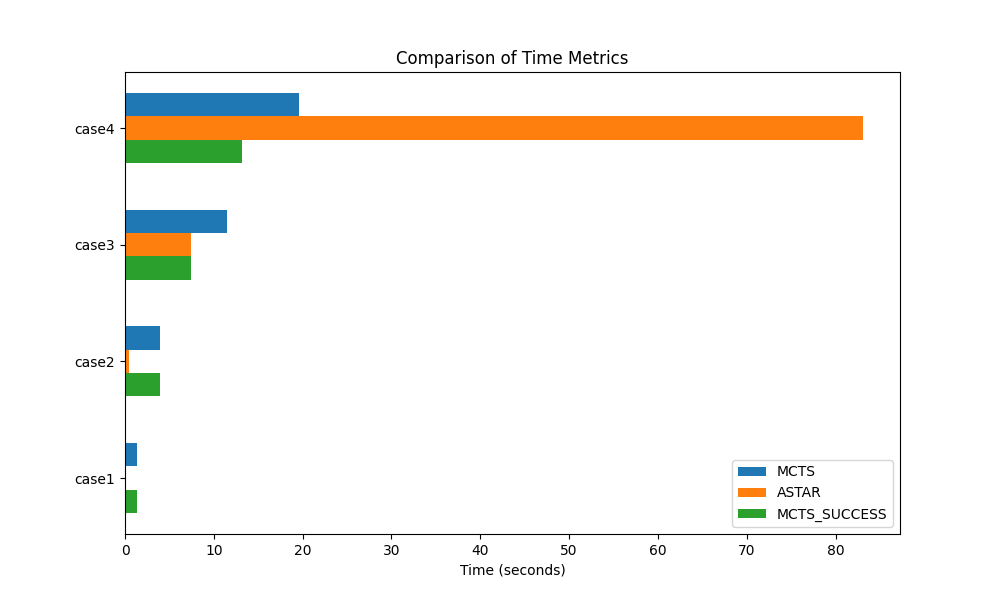

In [191]:
plt.close("all")
cases = ["case1", "case2", "case3", "case4"]
# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting MCTS_CMP_TIMES
ax.barh(np.arange(len(cases)) + 0.2, MCTS_CMP_TIMES_PDB, height=0.2, label="MCTS")

# Plotting ASTAR_TIMES[0]
ax.barh(np.arange(len(cases)), ASTAR_TIMES[0], height=0.2, label="ASTAR")

# Plotting MCTS_CMP_TIMES_SUCCESS
ax.barh(
    np.arange(len(cases)) - 0.2,
    MCTS_CMP_TIMES_SUCCESS_PDB,
    height=0.2,
    label="MCTS_SUCCESS",
)

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Time (seconds)")

# ax.set_xlim([0, 15])
# Set title
ax.set_title("Comparison of Time Metrics")

# Set y-axis limits to zoom in on Case 1 for ASTAR

# Add legend to the lower right side
ax.legend(loc="lower right")

# Display the plot
plt.show()
plt.savefig("plots/MCTS_ASTAR_TIMES_4.png", dpi=300)

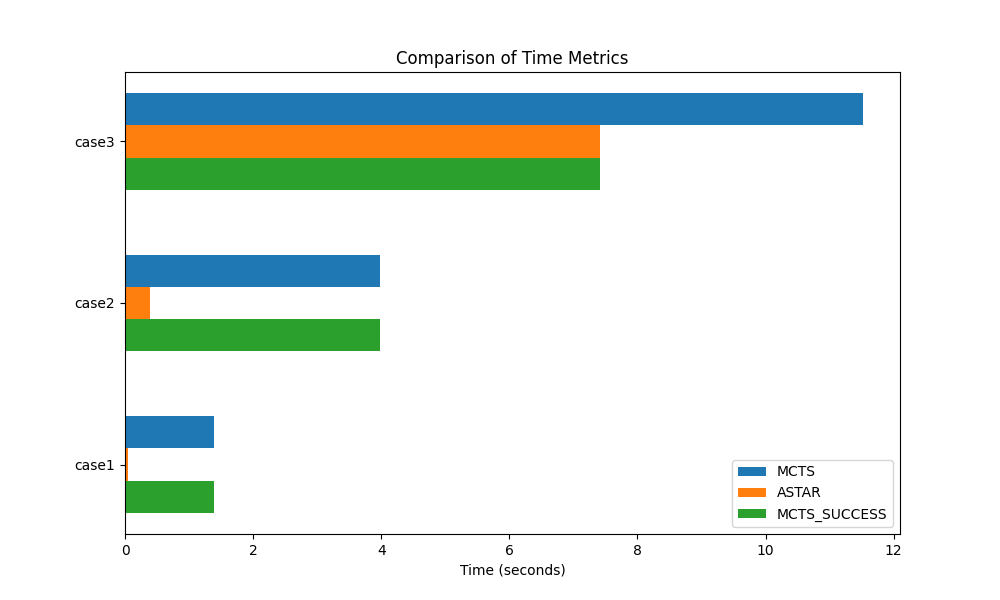

In [192]:
plt.close("all")
cases = ["case1", "case2", "case3"]
# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting MCTS_CMP_TIMES
ax.barh(
    np.arange(len(cases)) + 0.2, MCTS_CMP_TIMES_PDB[:-1], height=0.2, label="MCTS"
)

# Plotting ASTAR_TIMES[0]
ax.barh(np.arange(len(cases)), ASTAR_TIMES[0][:-1], height=0.2, label="ASTAR")

# Plotting MCTS_CMP_TIMES_SUCCESS
ax.barh(
    np.arange(len(cases)) - 0.2,
    MCTS_CMP_TIMES_SUCCESS_PDB[:-1],
    height=0.2,
    label="MCTS_SUCCESS",
)

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Time (seconds)")

# ax.set_xlim([0, 15])
# Set title
ax.set_title("Comparison of Time Metrics")

# Set y-axis limits to zoom in on Case 1 for ASTAR

# Add legend to the lower right side
ax.legend(loc="lower right")

# Display the plot
plt.show()
plt.savefig("plots/MCTS_ASTAR_TIMES.png", dpi=300)

### PATHS

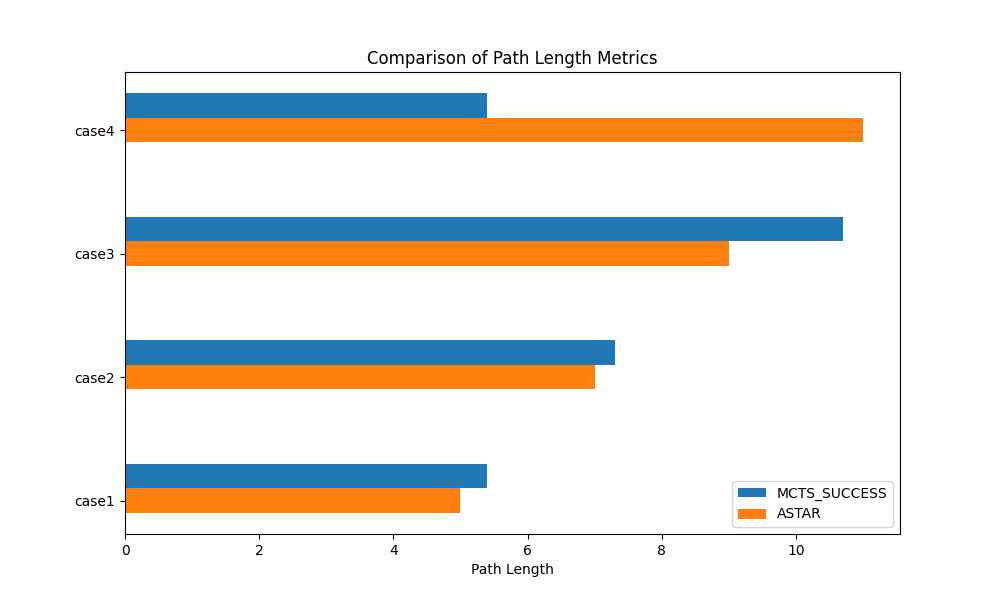

In [194]:
plt.close("all")
cases = ["case1", "case2", "case3", "case4"]
# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting MCTS_CMP_PATHS_SUCCESS
ax.barh(
    np.arange(len(cases)) + 0.2,
    MCTS_CMP_PATHS_SUCCESS_PDB,
    height=0.2,
    label="MCTS_SUCCESS",
)

# Plotting ASTAR_PATHS[0]
ax.barh(
    np.arange(len(cases)),
    [len(x) for x in ASTAR_PATHS[0]],
    height=0.2,
    label="ASTAR",
)

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Path Length")

# Set title
ax.set_title("Comparison of Path Length Metrics")

# Add legend to the lower right side
ax.legend(loc="lower right")

# Display the plot
plt.show()
plt.savefig("plots/MCTS_ASTAR_PATHS_4.png", dpi=300)

### STATES

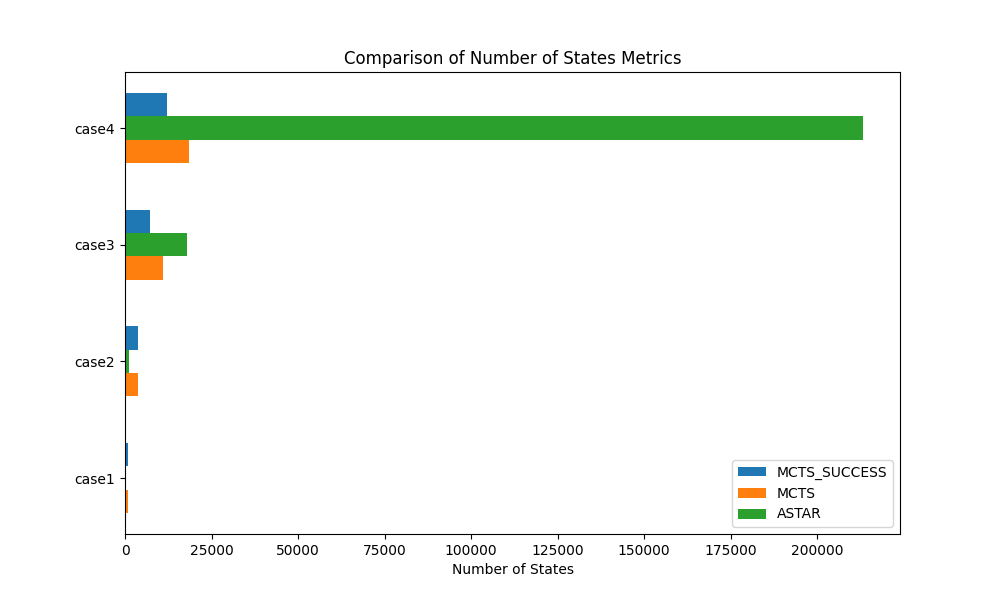

In [199]:
plt.close("all")
cases = ["case1", "case2", "case3", "case4"]
# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting MCTS_CMP_STATES_SUCCESS
ax.barh(
    np.arange(len(cases)) + 0.2,
    MCTS_CMP_STATES_SUCCESS_PDB,
    height=0.2,
    label="MCTS_SUCCESS",
)

# Plotting MCTS_CMP_STATES
ax.barh(
    np.arange(len(cases)) - 0.2, MCTS_CMP_STATES_PDB, height=0.2, label="MCTS"
)

# Plotting ASTAR_STATES[0]
ax.barh(np.arange(len(cases)), ASTAR_STATES[0], height=0.2, label="ASTAR")

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Number of States")

# Set title
ax.set_title("Comparison of Number of States Metrics")

# Add legend to the lower right side
ax.legend(loc="lower right")

# Display the plot
plt.show()
plt.savefig("plots/MCTS_ASTAR_STATES_4.png", dpi=300)

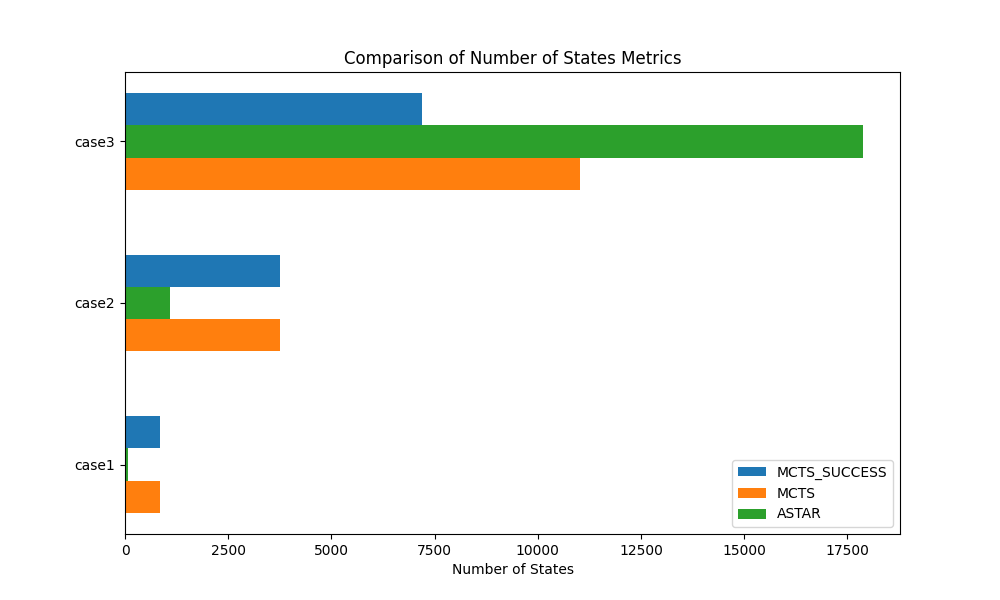

In [200]:
plt.close("all")
cases = ["case1", "case2", "case3"]
# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting MCTS_CMP_STATES_SUCCESS
ax.barh(
    np.arange(len(cases)) + 0.2,
    MCTS_CMP_STATES_SUCCESS_PDB[:-1],
    height=0.2,
    label="MCTS_SUCCESS",
)

# Plotting MCTS_CMP_STATES
ax.barh(
    np.arange(len(cases)) - 0.2,
    MCTS_CMP_STATES_PDB[:-1],
    height=0.2,
    label="MCTS",
)

# Plotting ASTAR_STATES[0]
ax.barh(np.arange(len(cases)), ASTAR_STATES[0][:-1], height=0.2, label="ASTAR")

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Number of States")

# Set title
ax.set_title("Comparison of Number of States Metrics")

# Add legend to the lower right side
ax.legend(loc="lower right")

# Display the plot
plt.show()
plt.savefig("plots/MCTS_ASTAR_STATES_3.png", dpi=300)

## MCTS vs BFS

### TIMES

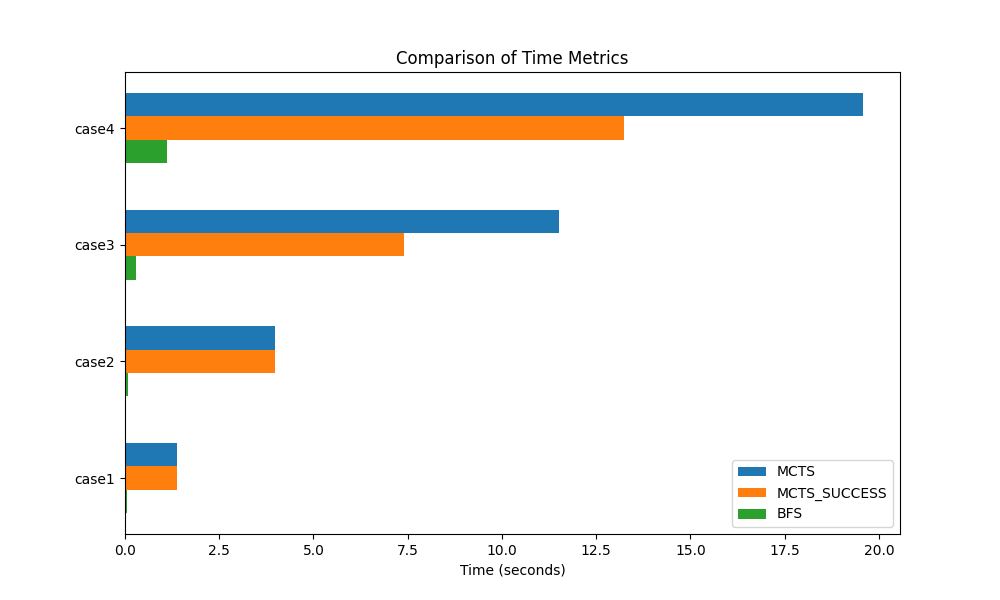

In [201]:
plt.close("all")
cases = ["case1", "case2", "case3", "case4"]
# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting MCTS_CMP_TIMES
ax.barh(np.arange(len(cases)) + 0.2, MCTS_CMP_TIMES_PDB, height=0.2, label="MCTS")

# Plotting MCTS_CMP_TIMES_SUCCESS
ax.barh(
    np.arange(len(cases)),
    MCTS_CMP_TIMES_SUCCESS_PDB,
    height=0.2,
    label="MCTS_SUCCESS",
)

# Plotting ASTAR_TIMES[0]
ax.barh(np.arange(len(cases)) - 0.2, BFS_TIMES[0], height=0.2, label="BFS")
# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Time (seconds)")

# ax.set_xlim([0, 15])
# Set title
ax.set_title("Comparison of Time Metrics")

# Set y-axis limits to zoom in on Case 1 for ASTAR

# Add legend to the lower right side
ax.legend(loc="lower right")

# Display the plot
plt.show()
plt.savefig("plots/MCTS_BFS_TIMES.png", dpi=300)

### PATHS

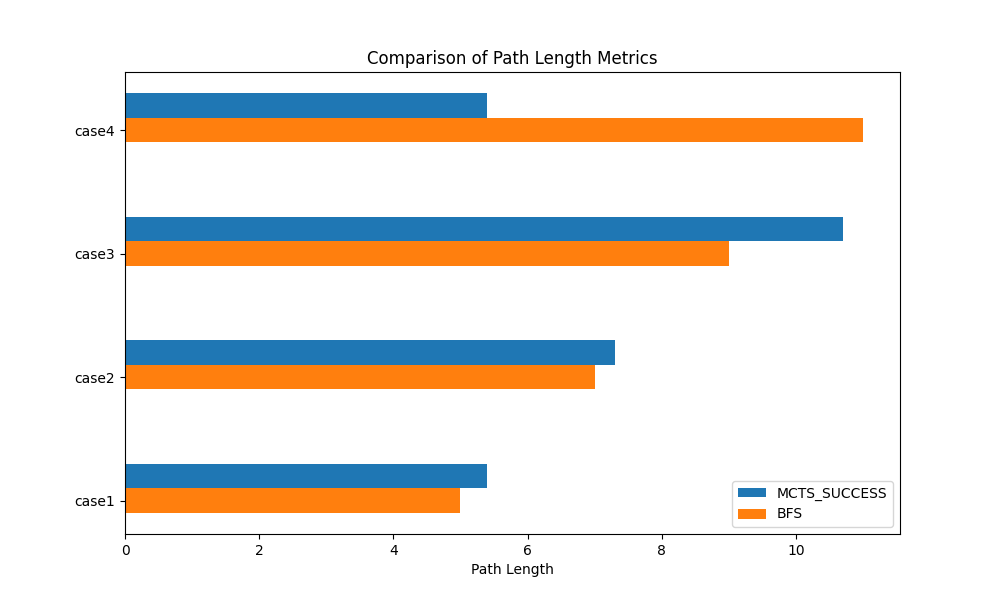

In [204]:
plt.close("all")
cases = ["case1", "case2", "case3", "case4"]
# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting MCTS_CMP_PATHS_SUCCESS
ax.barh(
    np.arange(len(cases)) + 0.2,
    MCTS_CMP_PATHS_SUCCESS_PDB,
    height=0.2,
    label="MCTS_SUCCESS",
)

# Plotting BFS_PATHS[0]
ax.barh(
    np.arange(len(cases)),
    [len(x) for x in BFS_PATHS[0]],
    height=0.2,
    label="BFS",
)

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Path Length")

# Set title
ax.set_title("Comparison of Path Length Metrics")

# Add legend to the lower right side
ax.legend(loc="lower right")

# Display the plot
plt.show()
plt.savefig("plots/MCTS_BFS_PATHS.png", dpi=300)

### STATES

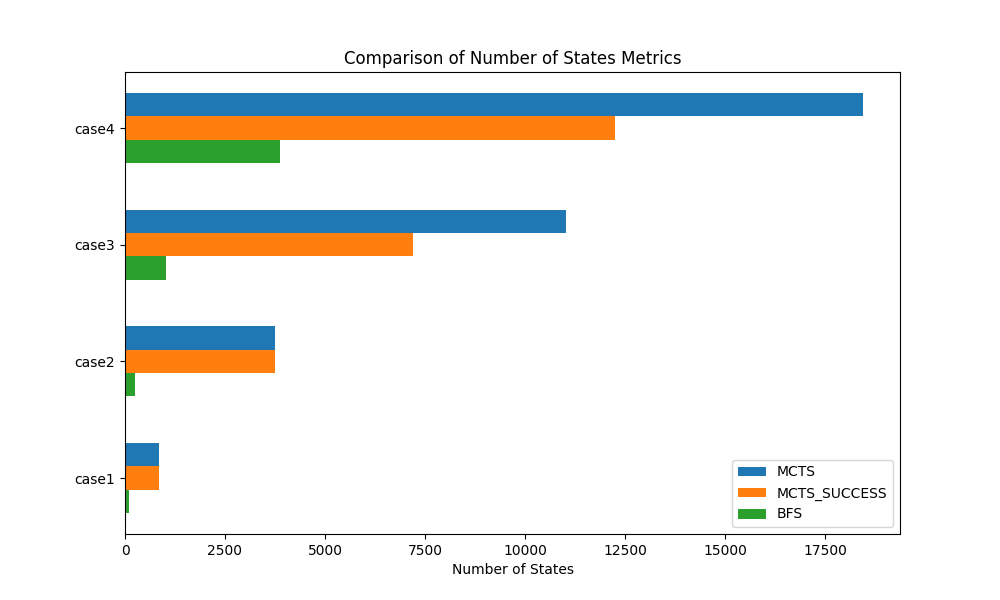

In [205]:
plt.close("all")
cases = ["case1", "case2", "case3", "case4"]
# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting MCTS_CMP_STATES
ax.barh(
    np.arange(len(cases)) + 0.2, MCTS_CMP_STATES_PDB, height=0.2, label="MCTS"
)

# Plotting MCTS_CMP_STATES_SUCCESS
ax.barh(
    np.arange(len(cases)),
    MCTS_CMP_STATES_SUCCESS_PDB,
    height=0.2,
    label="MCTS_SUCCESS",
)

# Plotting BFS_STATES
ax.barh(np.arange(len(cases)) - 0.2, BFS_STATES[0], height=0.2, label="BFS")

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Number of States")

# Set title
ax.set_title("Comparison of Number of States Metrics")

# Add legend to the lower right side
ax.legend(loc="lower right")

# Display the plot
plt.show()

# PATTERN DATABASE

## MCTS

### TIMES

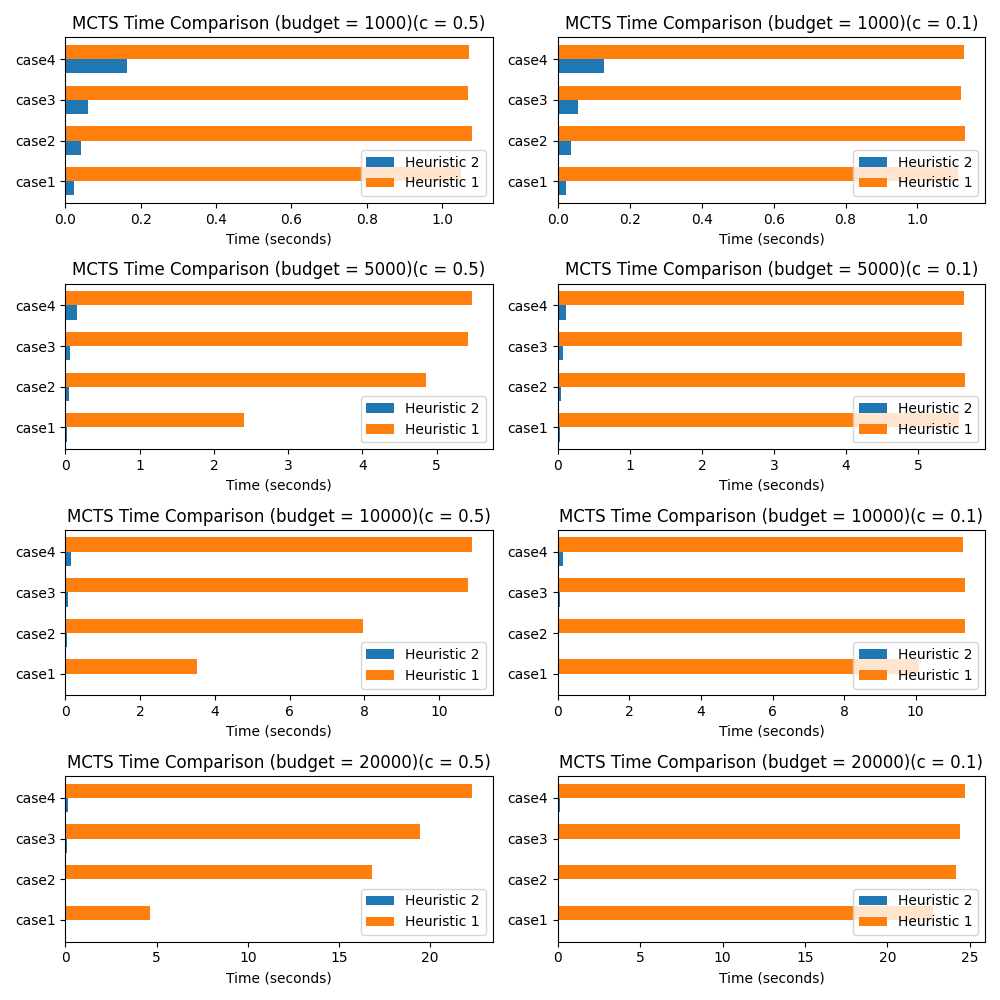

In [206]:
# Data for MCTS times
budgets = [1000, 5000, 10000, 20000]
cs = [0.5, 0.1]
cases = ["case1", "case2", "case3", "case4"]

plt.close("all")

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=len(budgets), ncols=len(cs), figsize=(10, 10))


# Iterate over each budget and c value and create a subplot for it
for i, budget in enumerate(budgets):
    for j, c in enumerate(cs):
        # Get the corresponding subplot
        ax = axs[i, j]

        # Get the MCTS times for the current budget and c value
        heuristic_1_times = MCTS_TIMES_ALL_BUDGETS_PDB[(budget, c)][0]
        heuristic_2_times = MCTS_TIMES_ALL_BUDGETS_PDB[(budget, c)][1]

        # Create horizontal bar chart for MCTS times on the subplot
        width = 0.35  # width of the bars
        y = range(len(heuristic_1_times))

        # Plot heuristic 2 times
        ax.barh(y, heuristic_2_times, height=width, label="Heuristic 2")
        # Plot heuristic 1 times
        ax.barh(
            [k + width for k in y], heuristic_1_times, height=width, label="Heuristic 1"
        )

        # Set y-axis labels and ticks
        ax.set_yticks([k + width / 2 for k in y])
        ax.set_yticklabels(cases)

        # Set x-axis label and ticks
        ax.set_xlabel("Time (seconds)")

        # Set title and legend
        ax.set_title(f"MCTS Time Comparison (budget = {budget})(c = {c})")
        ax.legend(loc="lower right")  # Move the legend to the bottom right side

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
plt.savefig("plots/MCTS_PDB_HEURISTICS.png", dpi=300)

### STATES

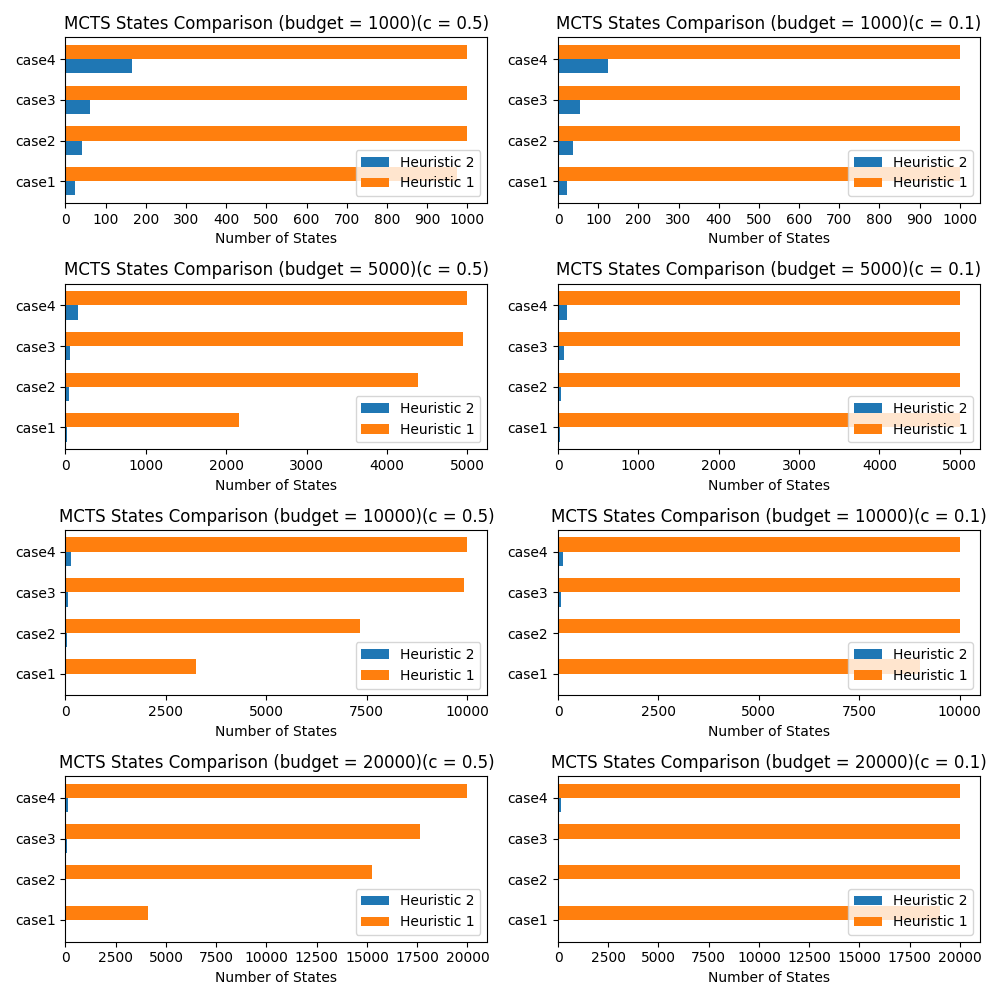

In [207]:
# Data for MCTS states
budgets = [1000, 5000, 10000, 20000]
cs = [0.5, 0.1]
cases = ["case1", "case2", "case3", "case4"]
# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=len(budgets), ncols=len(cs), figsize=(10, 10))

# Iterate over each budget and c value and create a subplot for it
for i, budget in enumerate(budgets):
    for j, c in enumerate(cs):
        # Get the corresponding subplot
        ax = axs[i, j]

        # Get the MCTS states for the current budget and c value
        heuristic_1_states = MCTS_STATES_ALL_BUDGETS_PDB[(budget, c)][0]
        heuristic_2_states = MCTS_STATES_ALL_BUDGETS_PDB[(budget, c)][1]

        # Create horizontal bar chart for MCTS states on the subplot
        width = 0.35  # width of the bars
        y = range(len(heuristic_1_states))

        # Plot heuristic 2 states
        ax.barh(y, heuristic_2_states, height=width, label="Heuristic 2")
        # Plot heuristic 1 states
        ax.barh(
            [k + width for k in y],
            heuristic_1_states,
            height=width,
            label="Heuristic 1",
        )

        # Set y-axis labels and ticks
        ax.set_yticks([k + width / 2 for k in y])
        ax.set_yticklabels(cases)

        ax.set_xticks(
            range(
                0,
                budget + 1,
                100 if budget == 1000 else 1000 if budget < 10000 else 2500,
            )
        )

        # Set x-axis label and ticks
        ax.set_xlabel("Number of States")

        # Set title and legend
        ax.set_title(f"MCTS States Comparison (budget = {budget})(c = {c})")
        ax.legend(loc="lower right")  # Move the legend to the bottom right side

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()
plt.savefig("plots/MCTS_PDB_HEURISTICS_STATES.png", dpi=300)

## MCTS vs A*

### create stats

In [208]:
MCTS_STATS_PDB_H3 = {}
if os.path.exists("mcts_stats_pdb_h3.pkl"):
    with open("mcts_stats_pdb_h3.pkl", "rb") as f:
        MCTS_STATS_PDB_H3 = pickle.load(f)
else:
    for case in ALL_CASES:
        result = test_mcts_stats(case, 20000, 0.5, new_heuristic)
        MCTS_STATS_PDB_H3[case] = result
    # Save mcts_stats to file
    with open("mcts_stats_pdb_h3.pkl", "wb") as file:
        pickle.dump(MCTS_STATS_PDB_H3, file)

In [209]:
cases = ["case1", "case2", "case3", "case4"]
labels = [
    "winrate",
    "average_states",
    "average_states_when_solution",
    "average_path_len",
    "average_run_time",
    "average_run_time_when_solution",
]
for name, k in zip(cases, MCTS_STATS_PDB_H3):
    print(f"Case {name}")
    for l, v in zip(labels, MCTS_STATS_PDB_H3[k]):
        print(f"\t{l}: {v}")

Case case1
	winrate: 0.95
	average_states: 4857.05
	average_states_when_solution: 4060.0526315789475
	average_path_len: 6.052631578947368
	average_run_time: 5.098194801807404
	average_run_time_when_solution: 4.2423261717746135
Case case2
	winrate: 0.7
	average_states: 12115.85
	average_states_when_solution: 8736.92857142857
	average_path_len: 7.714285714285714
	average_run_time: 12.66031539440155
	average_run_time_when_solution: 9.050194587026324
Case case3
	winrate: 0.2
	average_states: 19042.25
	average_states_when_solution: 15211.25
	average_path_len: 9.0
	average_run_time: 19.66145440340042
	average_run_time_when_solution: 15.6740180850029
Case case4
	winrate: 0.0
	average_states: 20000.0
	average_states_when_solution: 0
	average_path_len: 0
	average_run_time: 21.02925956249237
	average_run_time_when_solution: 0


In [210]:
MCTS_STATS_PDB_H4 = {}
if os.path.exists("mcts_stats_pdb_h4.pkl"):
    with open("mcts_stats_pdb_h4.pkl", "rb") as f:
        MCTS_STATS_PDB_H4 = pickle.load(f)
else:
    for case in ALL_CASES:
        result = test_mcts_stats(case, 1000, 0.1, new_heuristic_alone)
        MCTS_STATS_PDB_H4[case] = result
    # Save mcts_stats to file
    with open("mcts_stats_pdb_h4.pkl", "wb") as file:
        pickle.dump(MCTS_STATS_PDB_H4, file)

In [211]:
cases = ["case1", "case2", "case3", "case4"]
labels = [
    "winrate",
    "average_states",
    "average_states_when_solution",
    "average_path_len",
    "average_run_time",
    "average_run_time_when_solution",
]
for name, k in zip(cases, MCTS_STATS_PDB_H4):
    print(f"Case {name}")
    for l, v in zip(labels, MCTS_STATS_PDB_H4[k]):
        print(f"\t{l}: {v}")

Case case1
	winrate: 1.0
	average_states: 23.0
	average_states_when_solution: 23.0
	average_path_len: 5.0
	average_run_time: 0.021439886093139647
	average_run_time_when_solution: 0.021439886093139647
Case case2
	winrate: 1.0
	average_states: 36.9
	average_states_when_solution: 36.9
	average_path_len: 7.0
	average_run_time: 0.03457331657409668
	average_run_time_when_solution: 0.03457331657409668
Case case3
	winrate: 1.0
	average_states: 53.55
	average_states_when_solution: 53.55
	average_path_len: 9.5
	average_run_time: 0.05081743001937866
	average_run_time_when_solution: 0.05081743001937866
Case case4
	winrate: 1.0
	average_states: 112.4
	average_states_when_solution: 112.4
	average_path_len: 15.6
	average_run_time: 0.11319203376770019
	average_run_time_when_solution: 0.11319203376770019


In [212]:
MCTS_CMP_TIMES_SUCCESS_PDB = []
MCTS_CMP_PATHS_SUCCESS_PDB = []
MCTS_CMP_STATES_SUCCESS_PDB = []

for case in ALL_CASES:
    result = MCTS_STATS_PDB_H3[case]
    MCTS_CMP_TIMES_SUCCESS_PDB.append(result[5])
    MCTS_CMP_PATHS_SUCCESS_PDB.append(result[3])
    MCTS_CMP_STATES_SUCCESS_PDB.append(result[2])

In [213]:
MCTS_CMP_TIMES_PDB = []
MCTS_CMP_STATES_PDB = []

for case in ALL_CASES:
    result = MCTS_STATS_PDB_H3[case]
    MCTS_CMP_TIMES_PDB.append(result[4])
    MCTS_CMP_STATES_PDB.append(result[1])

In [214]:
MCTS_BEST_TIMES_SUCCESS_PDB = []
MCTS_BEST_PATHS_SUCCESS_PDB = []
MCTS_BEST_STATES_SUCCESS_PDB = []

for case in ALL_CASES:
    result = MCTS_STATS_PDB_H4[case]
    MCTS_BEST_TIMES_SUCCESS_PDB.append(result[5])
    MCTS_BEST_PATHS_SUCCESS_PDB.append(result[3])
    MCTS_BEST_STATES_SUCCESS_PDB.append(result[2])

In [215]:
MCTS_BEST_PATHS_SUCCESS_PDB

[5.0, 7.0, 9.5, 15.6]

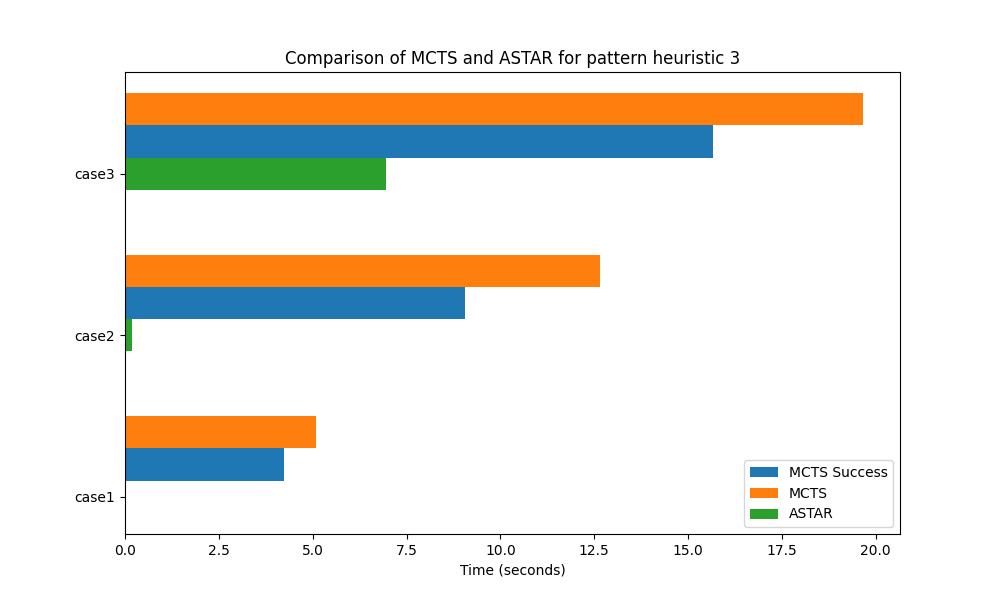

In [222]:
plt.close("all")

# Define the cases
cases = ["case1", "case2", "case3"]

# Get the MCTS_CMP_TIMES_SUCCESS_PDB for the first 3 cases
mcts_times_success = MCTS_CMP_TIMES_SUCCESS_PDB[:3]

# Get the MCTS_CMP_TIMES_PDB for the first 3 cases
mcts_times = MCTS_CMP_TIMES_PDB[:3]

# Get the ASTAR_TIMES_PDB for the first 3 cases
astar_times = ASTAR_TIMES_PDB[0][:3]

# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MCTS_CMP_TIMES_SUCCESS_PDB
ax.barh(
    np.arange(len(cases)) + 0.2, mcts_times_success, height=0.2, label="MCTS Success"
)

# Plot the MCTS_CMP_TIMES_PDB
ax.barh(np.arange(len(cases)) + 0.4, mcts_times, height=0.2, label="MCTS")

# Plot the ASTAR_TIMES_PDB
ax.barh(np.arange(len(cases)), astar_times, height=0.2, label="ASTAR")

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Time (seconds)")

# Set title
ax.set_title("Comparison of MCTS and ASTAR for pattern heuristic 3")

# Add legend to the lower right side
ax.legend(loc="lower right")

fig.savefig("plots/H3_PDB_MCTS_ASTAR_TIMES.png", dpi=300)

# Display the plot
plt.show()

In [141]:
print(ASTAR_TIMES_PDB[0])

[0.006394624710083008, 0.18954896926879883, 6.9454874992370605, 83.24540877342224]


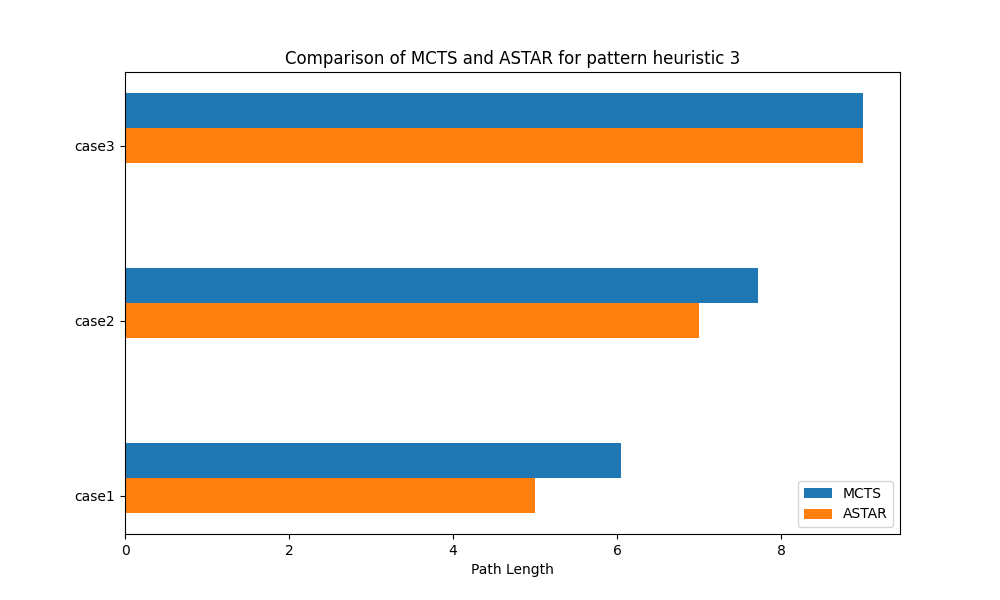

In [224]:
plt.close("all")

# Define the cases
cases = ["case1", "case2", "case3"]

# Get the MCTS_CMP_PATHS_SUCCESS_PDB for the first 3 cases
mcts_paths_success = MCTS_CMP_PATHS_SUCCESS_PDB[:3]

# Get the ASTAR_PATHS_PDB for the first 3 cases
astar_paths = ASTAR_PATHS_PDB[0][:3]

# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MCTS_CMP_PATHS_SUCCESS_PDB
ax.barh(np.arange(len(cases)) + 0.2, mcts_paths_success, height=0.2, label="MCTS")

# Plot the ASTAR_PATHS_PDB
ax.barh(np.arange(len(cases)), [len(x) for x in astar_paths], height=0.2, label="ASTAR")

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Path Length")

# Set title
ax.set_title("Comparison of MCTS and ASTAR for pattern heuristic 3")

# Add legend to the lower right side
ax.legend(loc="lower right")
fig.savefig("plots/H3_PDB_MCTS_ASTAR_PATHS.png", dpi=300)
# Display the plot
plt.show()

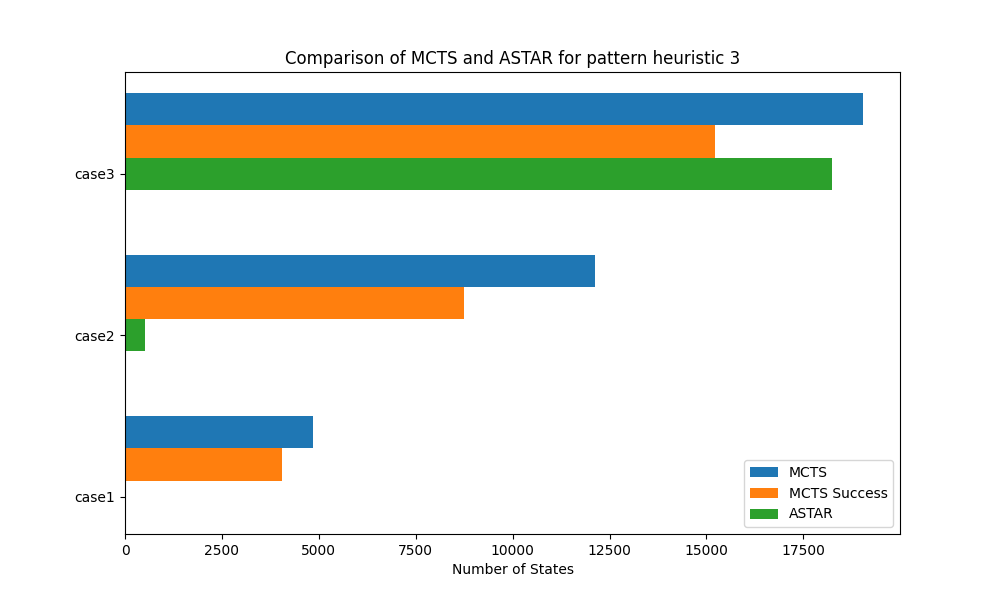

In [225]:
plt.close("all")

# Define the cases
cases = ["case1", "case2", "case3"]

# Get the MCTS_CMP_STATES_PDB for the first 3 cases
mcts_states = MCTS_CMP_STATES_PDB[:3]

# Get the MCTS_CMP_STATES_SUCCESS_PDB for the first 3 cases
mcts_states_success = MCTS_CMP_STATES_SUCCESS_PDB[:3]

# Get the ASTAR_STATES_PDB for the first 3 cases
astar_states = ASTAR_STATES_PDB[0][:3]

# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MCTS_CMP_STATES_PDB
ax.barh(np.arange(len(cases)) + 0.4, mcts_states, height=0.2, label="MCTS")

# Plot the MCTS_CMP_STATES_SUCCESS_PDB
ax.barh(
    np.arange(len(cases)) + 0.2, mcts_states_success, height=0.2, label="MCTS Success"
)

# Plot the ASTAR_STATES_PDB
ax.barh(np.arange(len(cases)), astar_states, height=0.2, label="ASTAR")

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Number of States")

# Set title
ax.set_title("Comparison of MCTS and ASTAR for pattern heuristic 3")

# Add legend to the lower right side
ax.legend(loc="lower right")

fig.savefig("plots/H3_PDB_MCTS_ASTAR_STATES.png", dpi=300)
# Display the plot
plt.show()

In [220]:
print(ASTAR_STATES_PDB[0])

[6, 523, 18241, 226180]


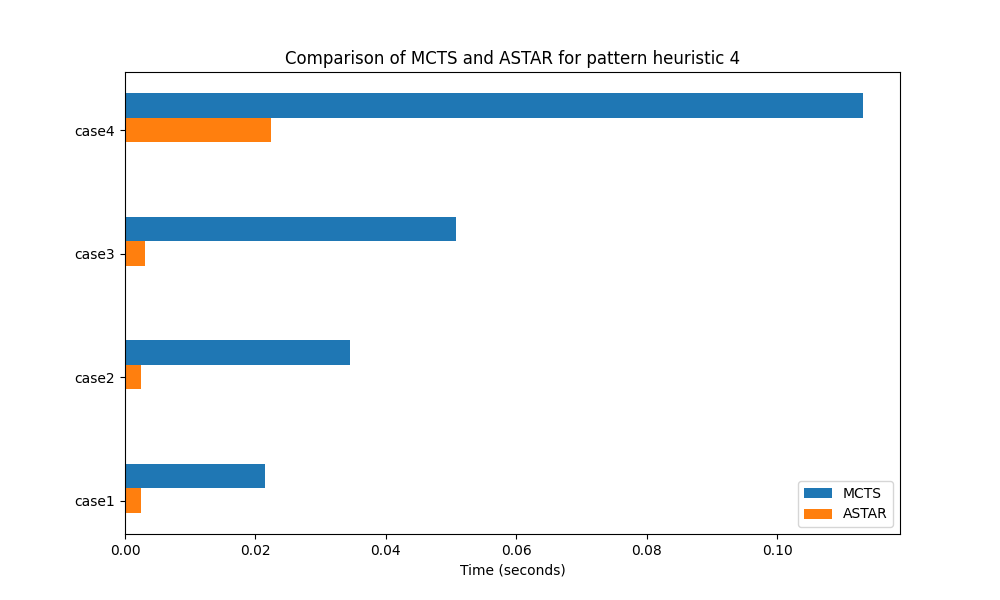

In [231]:
plt.close("all")

# Define the cases
cases = ["case1", "case2", "case3", "case4"]

# Get the MCTS_BEST_TIMES_SUCCESS_PDB for the first 4 cases
mcts_best_times_success = MCTS_BEST_TIMES_SUCCESS_PDB[:4]

# Get the ASTAR_TIMES_PDB for the second case
astar_times = ASTAR_TIMES_PDB[1]

# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MCTS_BEST_TIMES_SUCCESS_PDB
ax.barh(
    np.arange(len(cases)) + 0.2,
    mcts_best_times_success,
    height=0.2,
    label="MCTS",
)

# Plot the ASTAR_TIMES_PDB for the second case
ax.barh(np.arange(len(cases)), astar_times, height=0.2, label="ASTAR")

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Time (seconds)")

# Set title
ax.set_title("Comparison of MCTS and ASTAR for pattern heuristic 4")

# Add legend to the lower right side
ax.legend(loc="lower right")

fig.savefig("plots/H4_PDB_MCTS_ASTAR_TIMES.png", dpi=300)

# Display the plot
plt.show()

In [145]:
print(ASTAR_TIMES_PDB[1])
print(MCTS_BEST_TIMES_SUCCESS_PDB)

[0.002516031265258789, 0.0023932456970214844, 0.003002166748046875, 0.022457122802734375]
[0.021439886093139647, 0.03457331657409668, 0.05081743001937866, 0.11319203376770019]


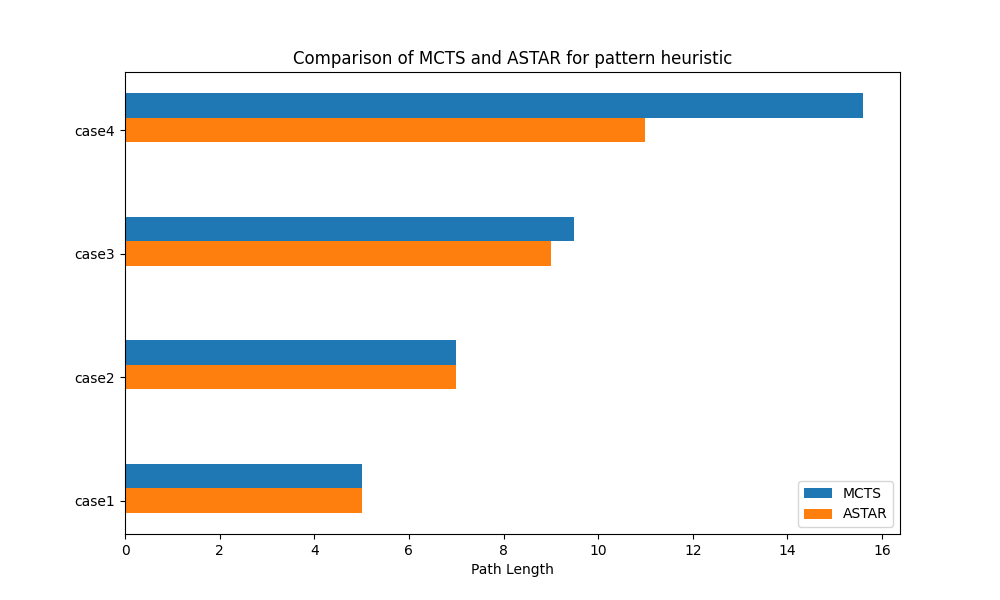

In [230]:
plt.close("all")

# Define the cases
cases = ["case1", "case2", "case3", "case4"]

# Get the MCTS_BEST_PATHS_SUCCESS_PDB for the first 4 cases
mcts_best_paths_success = MCTS_BEST_PATHS_SUCCESS_PDB[:4]

# Get the ASTAR_PATHS_PDB for the second case
astar_paths = ASTAR_PATHS_PDB[1]

# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MCTS_BEST_PATHS_SUCCESS_PDB
ax.barh(
    np.arange(len(cases)) + 0.2,
    mcts_best_paths_success,
    height=0.2,
    label="MCTS",
)

# Plot the ASTAR_PATHS_PDB for the second case
ax.barh(np.arange(len(cases)), [len(x) for x in astar_paths], height=0.2, label="ASTAR")

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Path Length")

# Set title
ax.set_title("Comparison of MCTS and ASTAR for pattern heuristic")

# Add legend to the lower right side
ax.legend(loc="lower right")

fig.savefig("plots/H4_PDB_MCTS_ASTAR_PATHS.png", dpi=300)

# Display the plot
plt.show()

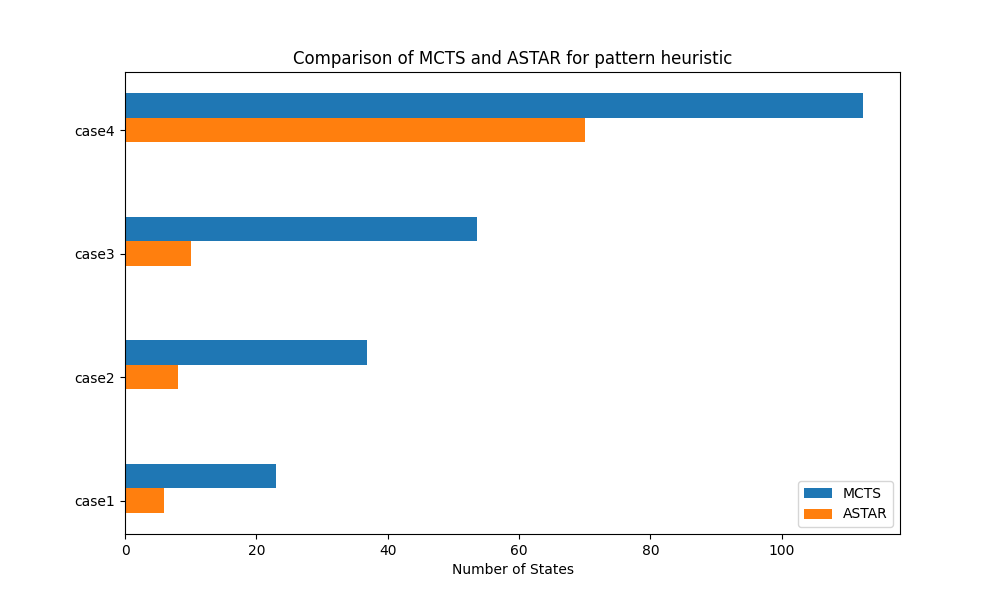

In [232]:
plt.close("all")

# Define the cases
cases = ["case1", "case2", "case3", "case4"]

# Get the MCTS_BEST_STATES_SUCCESS_PDB for the first 4 cases
mcts_best_states_success = MCTS_BEST_STATES_SUCCESS_PDB[:4]

# Get the ASTAR_STATES_PDB for the second case
astar_states = ASTAR_STATES_PDB[1]

# Create a figure and a grid of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the MCTS_BEST_STATES_SUCCESS_PDB
ax.barh(
    np.arange(len(cases)) + 0.2,
    mcts_best_states_success,
    height=0.2,
    label="MCTS",
)

# Plot the ASTAR_STATES_PDB for the second case
ax.barh(np.arange(len(cases)), astar_states, height=0.2, label="ASTAR")

# Set y-axis ticks and labels
ax.set_yticks(np.arange(len(cases)))
ax.set_yticklabels(cases)

# Set x-axis label
ax.set_xlabel("Number of States")

# Set title
ax.set_title("Comparison of MCTS and ASTAR for pattern heuristic")

# Add legend to the lower right side
ax.legend(loc="lower right")

fig.savefig("plots/H4_PDB_MCTS_ASTAR_STATES.png", dpi=300)
# Display the plot
plt.show()